In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, Markdown

import pandas as pd
import numpy as np

import json

np.__version__

/var/folders/b7/c67wpzpn25q0h072y9mmz_th0000gn/T/ipykernel_5454/2341679603.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


'1.26.3'

# Load, prep data

### Prep love song subtypes

In [2]:
OUTPUT_PATH = './data/22.2-OUTPUT-add-mjia-hand-labeling-and-relabel-uncategorized-using-them-as-exaples.csv'
love_song_subtype_df = pd.read_csv(OUTPUT_PATH)
love_song_subtype_df

performer                          song  \
0                                          10cc               I'm Not In Love   
1                                          ABBA                      Waterloo   
2                                           AWB                  Cut The Cake   
3                                       Aaliyah                  Back & Forth   
4                                 Aaron Neville      Everybody Plays The Fool   
...                                         ...                           ...   
5011                                       P!nk                           Try   
5012  Pitbull Featuring Ne-Yo, Afrojack & Nayer            Give Me Everything   
5013                                       Soko  We Might Be Dead By Tomorrow   
5014                               Taylor Swift                   Blank Space   
5015                           The Chainsmokers                         Paris   

                                          justification  \
0     a repeated denial of being in love, which sugg...   
1     compares being in love with surrender, as if l...   
2     symbolically about marriage but focuses on the...   
3     a song about having a good time, but not a spe...   
4     advising that everyone will be the fool in lov...   
...                                                 ...   
5011  about the inevitability of getting hurt when l...   
5012  about seizing the moment, with a blend of part...   
5013  emphasizing living in the current moment with ...   
5014  satirical view of the media's perception of he...   
5015  reflects on an escape with a partner, hinting ...   

            love_song_sub_type  
0             It's Complicated  
1                     Serenade  
2                          NaN  
3                          NaN  
4         Longing & Heartbreak  
...                        ...  
5011          It's Complicated  
5012  Courtship & Anticipation  
5013      Longing & Heartbreak  
5014          It's Complicated  
5015                  Serenade  

[5016 rows x 4 columns]

In [3]:
# TODO: gender is now exported from 22.5, with fine-grained labeling for each of the split names. 
# The rest of the notebook might need to be redone to use both the split names & the corresponding gender
gender_df = pd.read_csv('./data/11-OUTPUT-with-gender-from-gpt4.csv')
date_as_decimal = (gender_df.chart_debut_date_normalized_0_to_1 / 100) * (2023 - 1959) + 1959
date_as_decimal
gender_df['date_as_decimal'] = date_as_decimal
gender_df

grouped_by_song_df = gender_df.groupby(['performer', 'song']).first().reset_index()
grouped_by_song_df

performer  \
0            "Weird Al" Yankovic   
1                        'N Sync   
2                        'N Sync   
3                        'N Sync   
4                        'N Sync   
...                          ...   
5011             matchbox twenty   
5012           twenty one pilots   
5013           twenty one pilots   
5014           twenty one pilots   
5015  will.i.am & Britney Spears   

                                                 song generic_genre  \
0                                       White & Nerdy          ROCK   
1     (God Must Have Spent) A Little More Time On You           POP   
2                                         Bye Bye Bye           POP   
3                                    It's Gonna Be Me           POP   
4                                  This I Promise You           POP   
...                                               ...           ...   
5011                                           Unwell          ROCK   
5012                                         Heathens          ROCK   
5013                                             Ride          ROCK   
5014                                     Stressed Out          ROCK   
5015                                   Scream & Shout           POP   

                                             lyric_line chart_debut  \
0                      They see me mowin' my front lawn  2006-10-14   
1                                               Yeah...  1998-12-05   
2                                              Hey, hey  2000-01-29   
3                                    (It's gonna be me)  2000-05-06   
4                                           Oh oh oh oh  2000-09-30   
...                                                 ...         ...   
5011                                            All day  2003-03-22   
5012  All my friends are heathens, take it slow (In ...  2016-07-09   
5013          I just wanna stay in the sun where I find  2016-04-02   
5014  I wish I found some better sounds no one's eve...  2015-05-16   
5015                                   Bring the action  2012-12-15   

              x          y  chart_debut_date_normalized_0_to_1  \
0     50.912490  44.870985                              74.845   
1     81.288336  39.382591                              62.655   
2     71.402847  30.184848                              64.441   
3     68.789522  53.089582                              64.860   
4     74.214520  30.421922                              65.481   
...         ...        ...                                 ...   
5011  56.149341  35.176103                              69.317   
5012  58.202752  54.398868                              89.969   
5013  48.387025  35.286120                              89.550   
5014  60.782772  37.133766                              88.183   
5015  50.209962  46.394865                              84.441   

      genre_position_band  near_neighbors_count gender  date_as_decimal  
0                    10.0                     0      m       2006.90080  
1                     0.0                    12      m       1999.09920  
2                     0.0                    14      m       2000.24224  
3                     0.0                     0      m       2000.51040  
4                     0.0                    14      m       2000.90784  
...                   ...                   ...    ...              ...  
5011                 10.0                     7      m       2003.36288  
5012                 10.0                     0      m       2016.58016  
5013                 10.0                     1      m       2016.31200  
5014                 10.0                     1      m       2015.43712  
5015                  0.0                     1      x       2013.04224  

[5016 rows x 12 columns]

### Merge, add primary_performer column, replace NA with "none" (to re-use convention)

In [4]:
popularity_score_df = pd.read_csv('./data/21-OUTPUT-scored-with-sum-of-popularity-over-time.csv')

### Load name split & gender table

In [19]:
# PERFORMER_SPLIT_FILE = "./data/22.4-OUTPUT-performer_list_str-with-multi-name-artists-merged.csv"
CORRECTED_PERFORMER_NAME_SPLITS_PATH = './data/22.5-OUTPUT-2-corrected-name-splits-with_type_and_gender.csv'
performers_split_str_and_gender_df = pd.read_csv(CORRECTED_PERFORMER_NAME_SPLITS_PATH).set_index('performer')
performers_split_str_and_gender_df.loc['10cc']

performers_list_str                10cc|
gender_type_and_gender_list_str      gm|
type_and_gender_list_str             gm|
Name: 10cc, dtype: object

In [20]:
df = grouped_by_song_df.merge(love_song_subtype_df, on=['performer', 'song'], how='inner')
df.love_song_sub_type = df.love_song_sub_type.replace({np.nan: 'none'})

# merge in popularity score
df = df.merge(
    popularity_score_df,
    on=['performer', 'song'],
    how='left'
)

# Add a column performers_list_str, which is simply performers_split_str_and_gender_df[performer] for any given row
df['performers_list_str'] = df.performer.apply(lambda x: performers_split_str_and_gender_df.loc[x].performers_list_str)
df['type_and_gender_list_str'] = df.performer.apply(lambda x: performers_split_str_and_gender_df.loc[x].type_and_gender_list_str)

PERFORMER_LIST_DELIMITER = '|'
# Add a column primary_performer, which is the first performer in the list of delimited names (note that a performer ALWAYS ends in the delimiter, even if they're alone)
df['primary_performer'] = df.performers_list_str.apply(lambda x: x.split(PERFORMER_LIST_DELIMITER)[0])

df


performer  \
0            "Weird Al" Yankovic   
1                        'N Sync   
2                        'N Sync   
3                        'N Sync   
4                        'N Sync   
...                          ...   
4975             matchbox twenty   
4976           twenty one pilots   
4977           twenty one pilots   
4978           twenty one pilots   
4979  will.i.am & Britney Spears   

                                                 song generic_genre  \
0                                       White & Nerdy          ROCK   
1     (God Must Have Spent) A Little More Time On You           POP   
2                                         Bye Bye Bye           POP   
3                                    It's Gonna Be Me           POP   
4                                  This I Promise You           POP   
...                                               ...           ...   
4975                                           Unwell          ROCK   
4976                                         Heathens          ROCK   
4977                                             Ride          ROCK   
4978                                     Stressed Out          ROCK   
4979                                   Scream & Shout           POP   

                                             lyric_line chart_debut  \
0                      They see me mowin' my front lawn  2006-10-14   
1                                               Yeah...  1998-12-05   
2                                              Hey, hey  2000-01-29   
3                                    (It's gonna be me)  2000-05-06   
4                                           Oh oh oh oh  2000-09-30   
...                                                 ...         ...   
4975                                            All day  2003-03-22   
4976  All my friends are heathens, take it slow (In ...  2016-07-09   
4977          I just wanna stay in the sun where I find  2016-04-02   
4978  I wish I found some better sounds no one's eve...  2015-05-16   
4979                                   Bring the action  2012-12-15   

              x          y  chart_debut_date_normalized_0_to_1  \
0     50.912490  44.870985                              74.845   
1     81.288336  39.382591                              62.655   
2     71.402847  30.184848                              64.441   
3     68.789522  53.089582                              64.860   
4     74.214520  30.421922                              65.481   
...         ...        ...                                 ...   
4975  56.149341  35.176103                              69.317   
4976  58.202752  54.398868                              89.969   
4977  48.387025  35.286120                              89.550   
4978  60.782772  37.133766                              88.183   
4979  50.209962  46.394865                              84.441   

      genre_position_band  near_neighbors_count gender  date_as_decimal  \
0                    10.0                     0      m       2006.90080   
1                     0.0                    12      m       1999.09920   
2                     0.0                    14      m       2000.24224   
3                     0.0                     0      m       2000.51040   
4                     0.0                    14      m       2000.90784   
...                   ...                   ...    ...              ...   
4975                 10.0                     7      m       2003.36288   
4976                 10.0                     0      m       2016.58016   
4977                 10.0                     1      m       2016.31200   
4978                 10.0                     1      m       2015.43712   
4979                  0.0                     1      x       2013.04224   

                                          justification  \
0     a parody about nerd culture and stereotypes, n...   
1     expressing how special and perfect his love in...   
2     a song 

In [21]:
df[
    df.love_song_sub_type.isna()
]

df[
    df.love_song_sub_type == 'none'
]

performer            song generic_genre  \
0            "Weird Al" Yankovic   White & Nerdy          ROCK   
15             1910 Fruitgum Co.      Simon Says           POP   
16      21 Savage & Metro Boomin          Runnin       HIP_HOP   
29                       50 Cent   Disco Inferno       HIP_HOP   
30                       50 Cent      In Da Club       HIP_HOP   
...                          ...             ...           ...   
4970                        fun.     Some Nights           POP   
4976           twenty one pilots        Heathens          ROCK   
4977           twenty one pilots            Ride          ROCK   
4978           twenty one pilots    Stressed Out          ROCK   
4979  will.i.am & Britney Spears  Scream & Shout           POP   

                                             lyric_line chart_debut  \
0                      They see me mowin' my front lawn  2006-10-14   
15                      Simon Says Lyrics{Instrumental}  1968-01-27   
16                          Am I really hard to please?  2020-10-17   
29                           One, two, three, let's go!  2004-12-11   
30                               Go, go, go, go, go, go  2003-01-11   
...                                                 ...         ...   
4970      Some nights, I stay up cashing in my bad luck  2012-03-10   
4976  All my friends are heathens, take it slow (In ...  2016-07-09   
4977          I just wanna stay in the sun where I find  2016-04-02   
4978  I wish I found some better sounds no one's eve...  2015-05-16   
4979                                   Bring the action  2012-12-15   

              x          y  chart_debut_date_normalized_0_to_1  \
0     50.912490  44.870985                              74.845   
15    59.968664  31.805013                              14.736   
16    65.533044  54.440179                              96.615   
29    62.650390  33.050937                              72.003   
30    57.782846  41.490345                              69.022   
...         ...        ...                                 ...   
4970  52.417630  34.656863                              83.245   
4976  58.202752  54.398868                              89.969   
4977  48.387025  35.286120                              89.550   
4978  60.782772  37.133766                              88.183   
4979  50.209962  46.394865                              84.441   

      genre_position_band  near_neighbors_count gender  date_as_decimal  \
0                    10.0                     0      m       2006.90080   
15                    0.0                     0      m       1968.43104   
16                   20.0                     0      m       2020.83360   
29                   20.0                    13      m       2005.08192   
30                   20.0                     9      m       2003.17408   
...                   ...                   ...    ...              ...   
4970                  0.0                     0      m       2012.27680   
4976                 10.0                     0      m       2016.58016   
4977                 10.0                     1      m       2016.31200   
4978                 10.0                     1      m       2015.43712   
4979                  0.0                     1      x       2013.04224   

                                          justification love_song_sub_type  \
0     a parody about nerd culture and stereotypes, n...               none   
15    a fun, danceable song modeled after the childr...               none   
16                          a gangster rap, not romance               none   
29    a party song celebrating having a good time at...               none   
30    a song about celebrating wealth and success, n...               none   
...                                                 ...                ...   
4970  explores existential musings, no clear romanti...               none   
4976                 about social outcasts, not romance    

# Export data for use in Svelte app prototype

In [23]:
viz_export_ready_df = df[[
    # 'performer', 
    'performers_list_str', # using this parsaable list of performers instead
    'song', 
    # 'generic_genre', # drop genre for now
    #'gender', # we have a sub-artist specific granularity for now
    'type_and_gender_list_str',
    'date_as_decimal', 'love_song_sub_type', 'popularity_score'
]]

# Rename Platonic Love to 'none' (since we don't decided not to keep it as a love song sub type)
viz_export_ready_df.love_song_sub_type = viz_export_ready_df.love_song_sub_type.replace('Platonic Love', 'none')

# Now, make it skinnier
viz_export_ready_df.love_song_sub_type = viz_export_ready_df.love_song_sub_type.replace('none', '')

viz_export_ready_df.date_as_decimal = viz_export_ready_df.date_as_decimal.round(2)

viz_export_ready_df = viz_export_ready_df.sort_values('date_as_decimal')

viz_export_ready_df.to_json(
    'data/23-EXPORT-viz-ready-data.json',
    orient="values",
)

# GENERATE A KEY since we're just using index to keep the json small
{col: i for i, col in enumerate(viz_export_ready_df.columns)}

# viz_export_ready_df

/var/folders/b7/c67wpzpn25q0h072y9mmz_th0000gn/T/ipykernel_5454/1937714277.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_export_ready_df.love_song_sub_type = viz_export_ready_df.love_song_sub_type.replace('Platonic Love', 'none')
/var/folders/b7/c67wpzpn25q0h072y9mmz_th0000gn/T/ipykernel_5454/1937714277.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_export_ready_df.love_song_sub_type = viz_export_ready_df.love_song_sub_type.replace('none', '')
/var/folders/b7/c67wpzpn25q0h072y9mmz_th000

{'performers_list_str': 0,
 'song': 1,
 'type_and_gender_list_str': 2,
 'date_as_decimal': 3,
 'love_song_sub_type': 4,
 'popularity_score': 5}

# Export data for MJia's hand review

In [48]:
# NOTE: redo viz_export_ready_df but don't make 'none' be an empty string

viz_export_ready_df = df[[
    'performer', 'song', 'generic_genre', 'justification', 'gender', 'date_as_decimal', 'love_song_sub_type'
]]

viz_export_ready_df.date_as_decimal = viz_export_ready_df.date_as_decimal.round(2)

lyric_df = pd.read_csv('./data/2 OUTPUT Songs with lyrics.csv')[['song', 'performer', 'lyrics']]

with_lyrics = viz_export_ready_df.merge(
    right=lyric_df,
    on=['song', 'performer'],
    how='inner'
).drop(columns=['generic_genre', 'gender'])

with_lyrics = with_lyrics[
    (with_lyrics.love_song_sub_type != '')
    & (with_lyrics.love_song_sub_type != 'none') 
    & (with_lyrics.date_as_decimal >= 2009) # she just wants to see songs we likely are familiar with   
]

# add youtube to search google

with_lyrics['youtube_url'] = with_lyrics.apply(
    lambda row: f'https://www.youtube.com/results?search_query={row.song}+by+{row.performer}'.replace(" ", "+"),
    axis=1
)

# with_lyrics.to_csv('data/23-EXPORT-with-lyrics-for-mjia-gSheets-inspection.csv', index=False)

with_lyrics

/var/folders/b7/c67wpzpn25q0h072y9mmz_th0000gn/T/ipykernel_35606/3362176365.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_export_ready_df.date_as_decimal = viz_export_ready_df.date_as_decimal.round(2)


performer               song  \
17       21 Savage & Metro Boomin Featuring Drake      Mr. Right Now   
18                   24kGoldn Featuring iann dior               Mood   
26                          3OH!3 Featuring Ke$ha      My First Kiss   
28                            5 Seconds Of Summer         Youngblood   
40    6ix9ine Featuring Nicki Minaj & Murda Beatz               FEFE   
...                                           ...                ...   
4965                    Zedd, Maren Morris & Grey         The Middle   
4968               benny blanco, BTS & Snoop Dogg      Bad Decisions   
4969                benny blanco, Halsey & Khalid           Eastside   
4971                 fun. Featuring Janelle Monae       We Are Young   
4972               gnash Featuring Olivia O'Brien  I Hate U I Love U   

                                          justification  date_as_decimal  \
17    brags about his ability to be the current roma...          2020.83   
18    bemoans why his female love interest is always...          2020.67   
26    reminiscing about a first kiss, which is a fon...          2010.49   
28    addresses the complexity of a relationship and...          2018.51   
40     about sexual prowess with many sexual references          2018.64   
...                                                 ...              ...   
4965  pleading with a lover to meet in the 'middle',...          2018.16   
4968  a playful, infatuated proclamation of all he i...          2022.65   
4969  reminiscing about the innocence of young love ...          2019.05   
4971  about supporting someone through hard moments,...          2012.07   
4972  expressing the torment and confusion of linger...          2016.41   

            love_song_sub_type  \
17             Sexual Conquest   
18            It's Complicated   
26    Courtship & Anticipation   
28            It's Complicated   
40             Sexual Conquest   
...                        ...   
4965          It's Complicated   
4968  Courtship & Anticipation   
4969      Longing & Heartbreak   
4971             Platonic Love   
4972          It's Complicated   

                                                 lyrics  \
17    TranslationsРусскийMr. Right Now Lyrics[Intro:...   
18    TranslationsTürkçeMood Lyrics[Intro: 24kGoldn]...   
26    My First Kiss Lyrics[Intro: Sean Foreman & Ke$...   
28    TranslationsEspañolPortuguêsYoungblood Lyrics[...   
40    TranslationsEspañolPortuguêsEnglishEestiFEFE L...   
...                                                 ...   
4965  TranslationsFrançaisThe Middle Lyrics[Verse 1:...   
4968  TranslationsTürkçePortuguêsहिन्दीBad Decisions...   
4969  TranslationsEspañolEastside Lyrics[Intro: Khal...   
4971  We Are Young Lyrics[Verse 1: Nate Ruess]\nGive...   
4972  ​i​ hate u, i love u Lyrics[Verse 1: Olivia O'...   

                                            youtube_url  
17    https://www.youtube.com/results?search_query=M...  
18    https://www.youtube.com/results?search_query=M...  
26    https://www.youtube.com/results?search_query=M...  
28    https://www.youtube.com/results?search_query=Y...  
40    https://www.youtube.com/results?search_query=F...  
...                                                 ...  
4965  https://www.youtube.com/results?search_query=T...  
4968  https://www.youtube.com/results?search_query=B...  
4969  https://www.youtube.com/results?search_query=E...  
4971  https://www.youtube.com/results?search_query=W...  
4972  https://www.youtube.com/results?search_query=I...  

[485 rows x 7 columns]

# Do preliminary exploration of love song sub types

In [49]:
LOVE_SONG_SUB_TYPES = df.love_song_sub_type.unique()
LOVE_SONG_SUB_TYPES

array(['none', 'Serenade', 'Good Riddance', 'Courtship & Anticipation',
       "It's Complicated", 'Sexual Conquest', 'Platonic Love',
       'Longing & Heartbreak', 'Love Song for the Self'], dtype=object)

## How do they vary over time?

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
COLOR_MAP = {
    'none': 'gray',

    'Serenade': 'pink',
    'Longing & Heartbreak': 'blue',
    'Sexual Conquest': 'red',
    "It's Complicated": 'brown',
    'Good Riddance': 'purple',
    'Love Song for the Self': 'orange',
    'Platonic Love': 'yellow',
    
    # New categories:
    'Courtship & Anticipation': 'green',
}
    
def stacked_bars_over_time(df, subtypes_to_include=LOVE_SONG_SUB_TYPES, title_prepend='', num_quarters_for_rolling_window=8):
    # Rename the types that we will AGGREGATE
    filtered_df = df.copy()
    filtered_df['love_song_sub_type'] = filtered_df['love_song_sub_type'].apply(lambda _type: _type if _type in subtypes_to_include else 'none')
    # Filter the DataFrame to include only the specified subtypes
#     filtered_df = df[df['love_song_sub_type'].isin(subtypes_to_include)]

    # Group by subtype and then calculate the count for each 0.25 interval in date_as_decimal
    grouped_df = filtered_df.groupby(['love_song_sub_type', (filtered_df['date_as_decimal']*4).astype(int)/4]).size().reset_index(name='count')
    grouped_df.rename(columns={'date_as_decimal': 'quarterly_decimal'}, inplace=True)

    # Pivot the DataFrame so that love_song_sub_type becomes the columns, the date is the index, and the values are the counts
    pivoted_df = grouped_df.pivot(index='quarterly_decimal', columns='love_song_sub_type', values='count').fillna(0)

    # Calculate the total number of songs for each quarterly interval
    quarterly_totals = pivoted_df.sum(axis=1)

    # Divide by the quarterly totals to get the percentages
    pivoted_df = pivoted_df.divide(quarterly_totals, axis=0) * 100

    # Apply a rolling mean with a window of size 2 to smooth over two quarters (i.e., 6 months)
    pivoted_df = pivoted_df.rolling(
        window=num_quarters_for_rolling_window
    ).mean().dropna()

      # Sort the columns by their total sum to get the most popular category on top
    sorted_columns = pivoted_df.sum().sort_values(ascending=True).index
    pivoted_df = pivoted_df[sorted_columns]

    # Define the colors for the areas based on the sorted columns
    colors = [COLOR_MAP[subtype] for subtype in sorted_columns]

    # Create a stacked area plot with the specified colors
    plt.figure(figsize=(15, 8))
    stack_coll = plt.stackplot(pivoted_df.index, pivoted_df.T, colors=colors, alpha=0.5)

    # Label the areas directly on the plot, centered within each area
    for i, subtype in enumerate(sorted_columns):
        y_offset = pivoted_df.iloc[:, :i].sum(axis=1).rolling(window=2).mean().dropna().values
        y_values = pivoted_df[subtype].rolling(window=2).mean().dropna().values
        y_mid = y_offset + y_values / 2
        x_values = pivoted_df.index
        plt.text(x_values[len(x_values)//2], y_mid[len(y_mid)//2], subtype, ha='center', va='center')

    plt.title(f'{title_prepend} Love Song Subtypes Over Time (percentage of total, rolling average)')
    plt.xlabel('Year')
    plt.xlim(1958, 2022)
    plt.ylim(0, 100)  # Set y-axis limits to 0-100
    plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')  # Add faint gray horizontal grid lines
    plt.yticks(range(0, 101, 10))  
    plt.ylabel('Percentage of Total Songs')
    plt.show()


## All songs over time: 

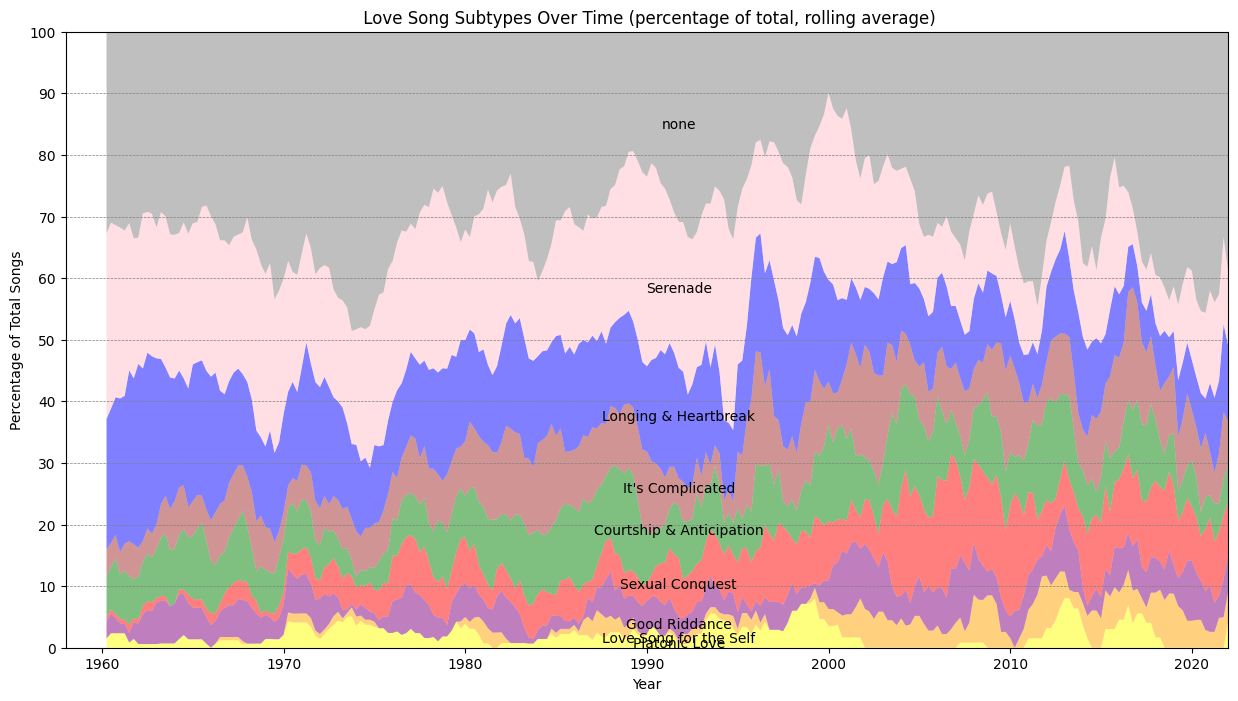

In [52]:
stacked_bars_over_time(df, num_quarters_for_rolling_window=6)

## Looking at just traditional categories of "love song", after starting above 50% in 1950, they unambiguously fell off starting in 2003, and are now around 30%.

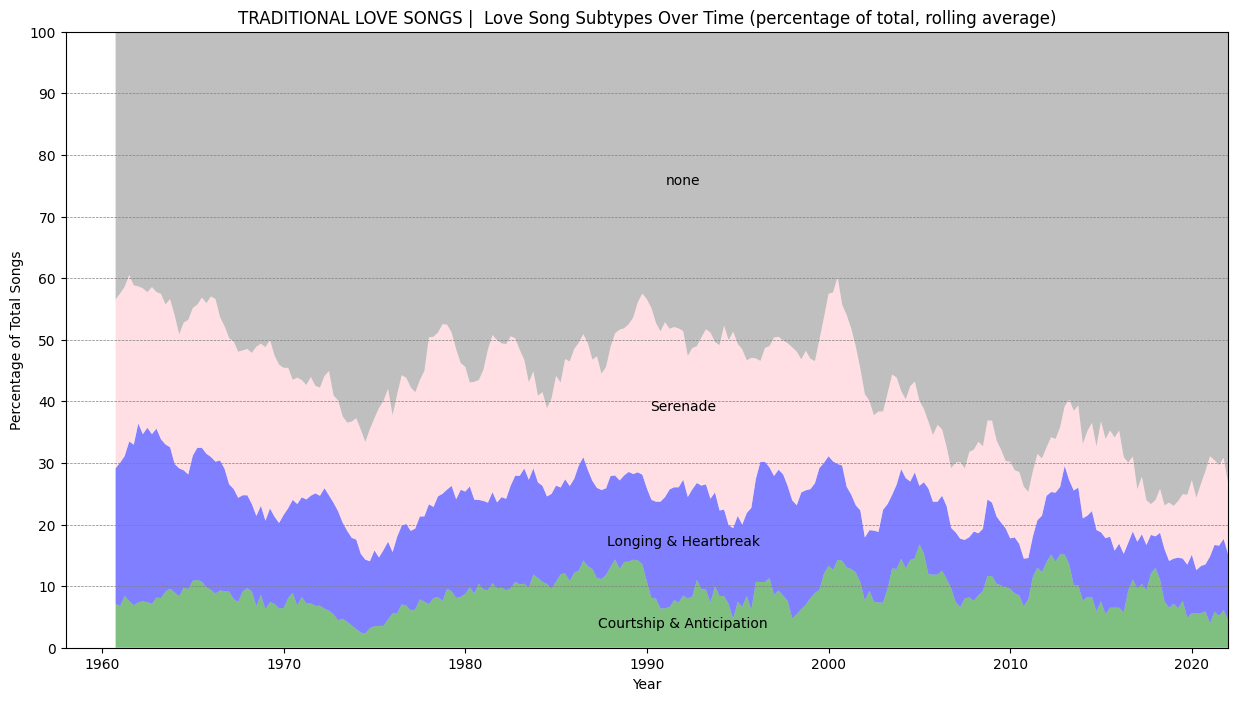

In [53]:
NOT_VERY_LOVE_SONGY_TYPES = [
    'none', 'Sexual Conquest', 'Love Song for the Self', 'Platonic Love', 'Good Riddance', "It's Complicated",
]

stacked_bars_over_time(
    df, 
    [s for s in LOVE_SONG_SUB_TYPES if s not in NOT_VERY_LOVE_SONGY_TYPES], 
    title_prepend="TRADITIONAL LOVE SONGS | "
)

## Split by gender

### Observations
- WOMEN largely created the "Love song for the self", AND and it dominates starting in 2010
- WOMEN were headed for a "Serenade"-less world from 2000-2015, but it made a comeback around the 2020s
- WOMEN burst onto the scene with "Sexual Conquest" in the mid 70s, while MEN waited until the 2000s to make it a substantial proportion of their songs
- WOMEN have more "Good Riddance" than MEN throughout time
- In the 60s, "Longing & Heartbreak" dominated for WOMEN, but steadily faded
- *non-love-songs* are the dominant categories for MEN, while women sport a more equal distribution, with "Serenade" often at the top.

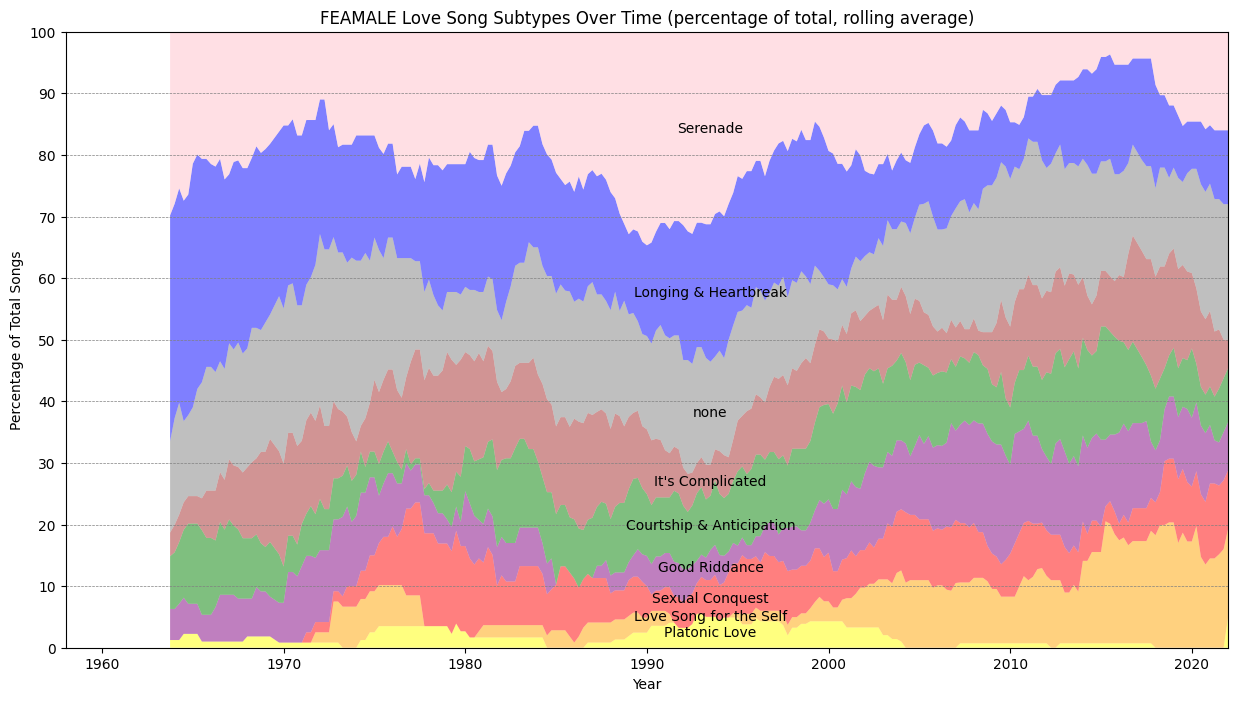

In [54]:
stacked_bars_over_time(df[df.gender == 'f'], title_prepend='FEAMALE', num_quarters_for_rolling_window=20)

### Men:

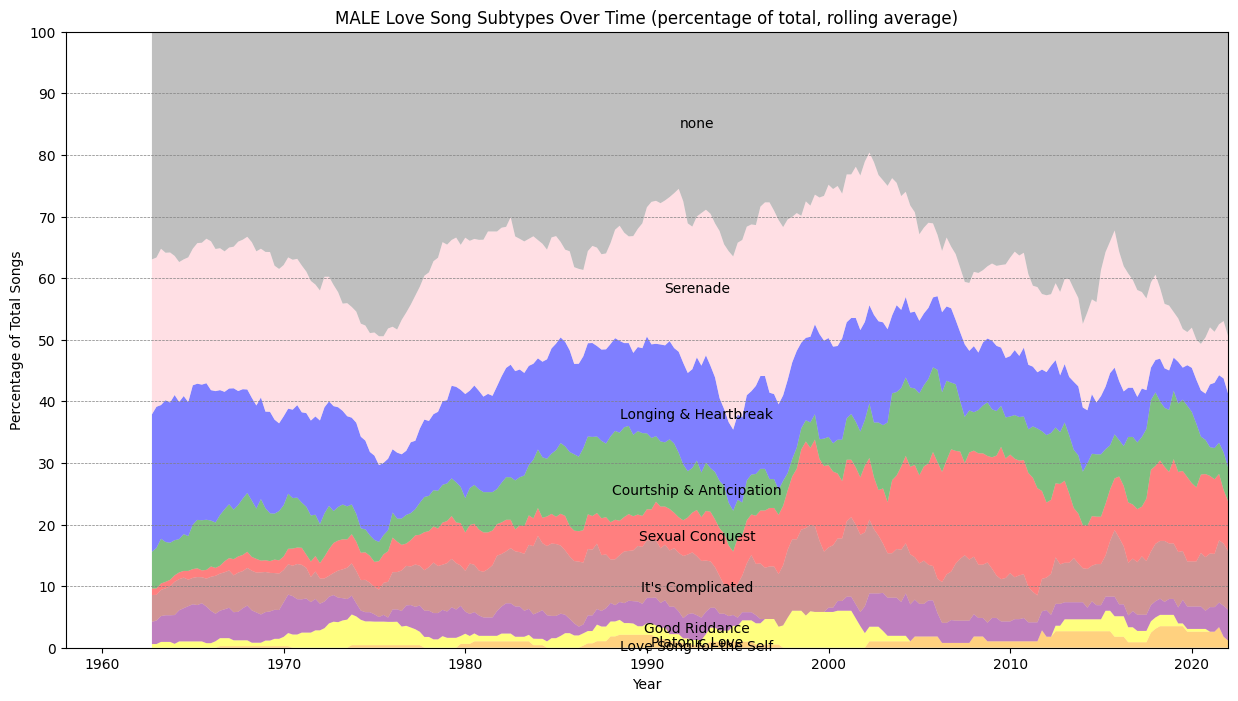

In [55]:
stacked_bars_over_time(df[df.gender == 'm'], title_prepend='MALE', num_quarters_for_rolling_window=16)

## ... gender, but only for classical love songs:

### observations:
- For BOTH, classical love songs fell off shartply in the early 2000s
- BOTH end around 30%, but WOMEN feel futher (from 70% in the 1960s vs MENS 50%)

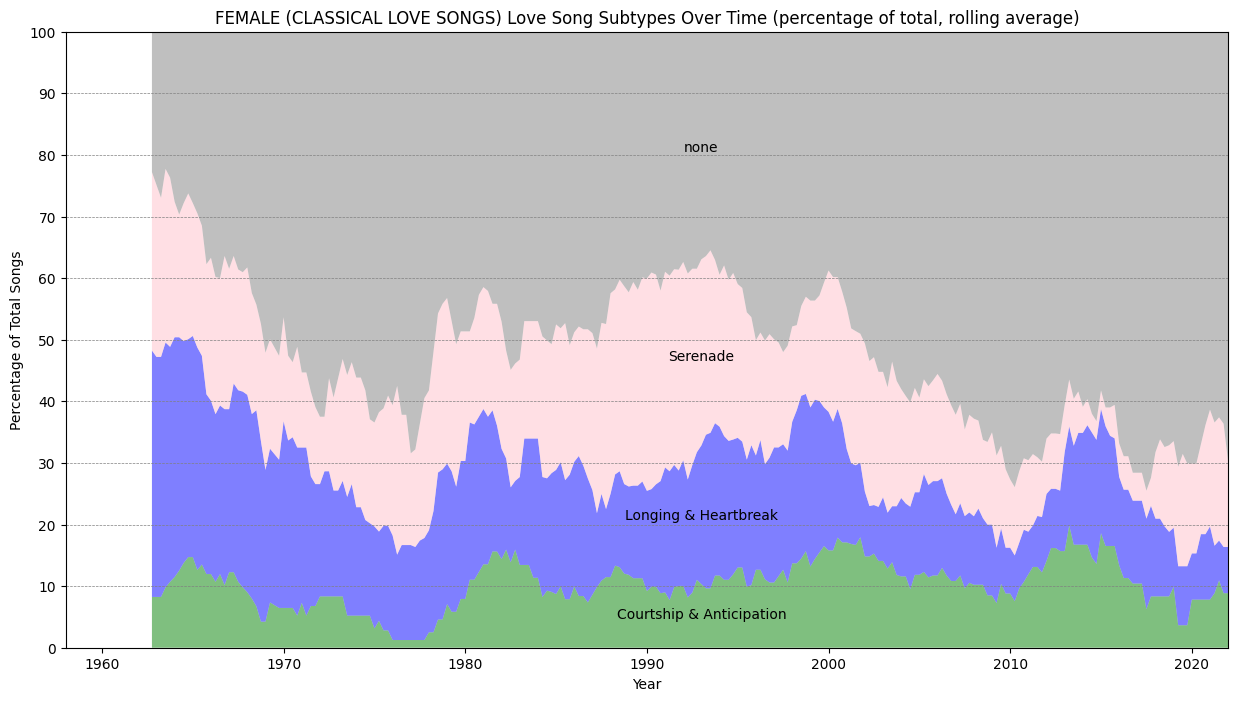

In [56]:
stacked_bars_over_time(
    df[
        df.gender == 'f'
    ], 
    subtypes_to_include=[s for s in LOVE_SONG_SUB_TYPES if s not in NOT_VERY_LOVE_SONGY_TYPES],
    title_prepend='FEMALE (CLASSICAL LOVE SONGS)',
    num_quarters_for_rolling_window=16
)

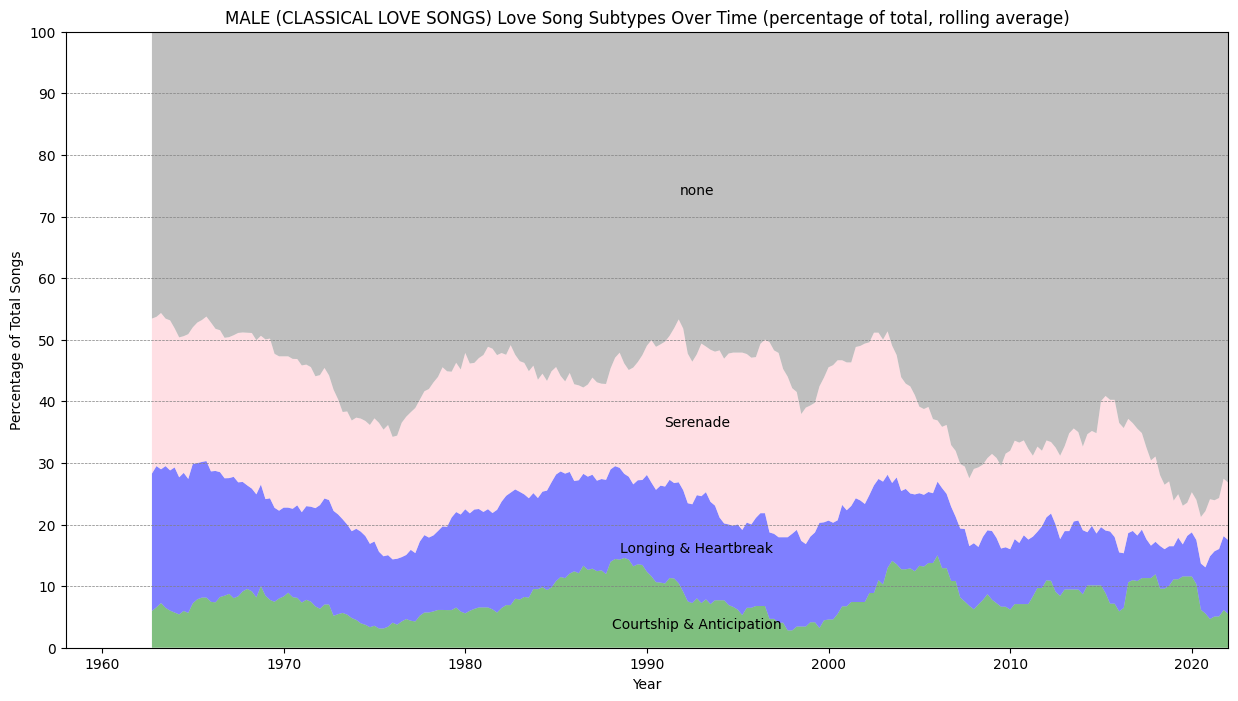

In [57]:
stacked_bars_over_time(
    df[
        df.gender == 'm'
    ], 
    subtypes_to_include=[s for s in LOVE_SONG_SUB_TYPES if s not in NOT_VERY_LOVE_SONGY_TYPES],
    title_prepend='MALE (CLASSICAL LOVE SONGS)',
    num_quarters_for_rolling_window=16
)

## (one hit wonders follow the general trend for what's popular)

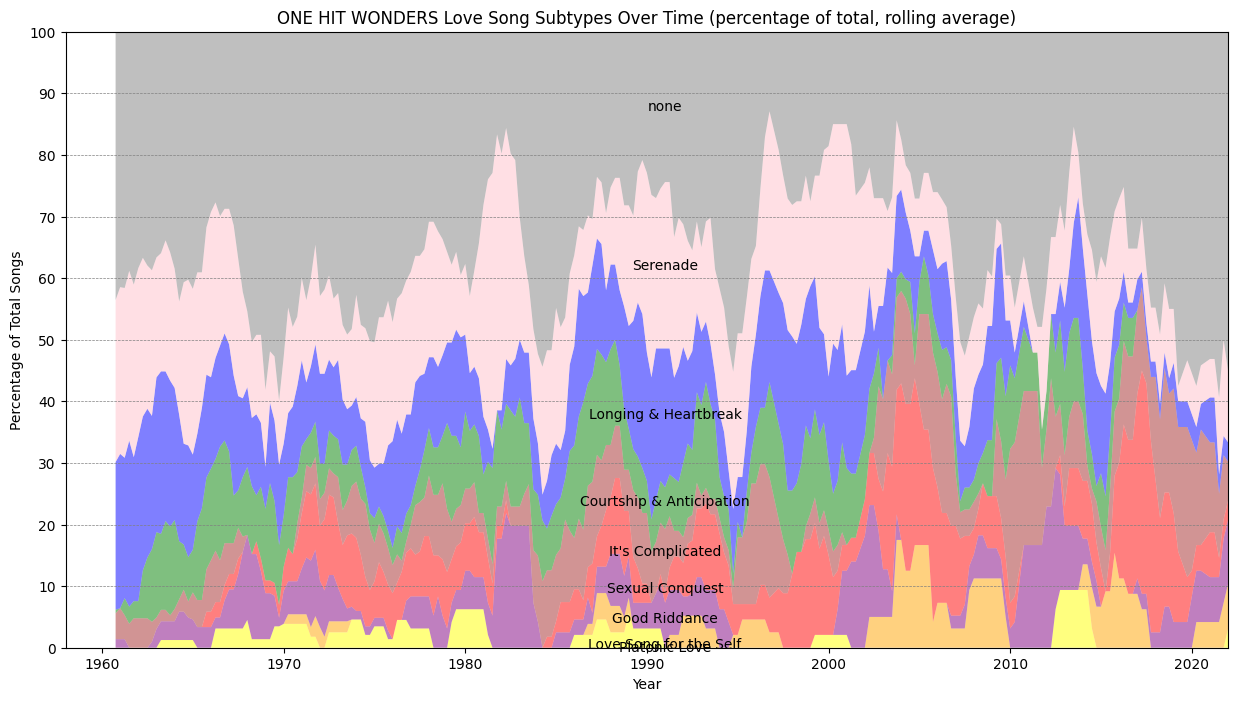

In [58]:
one_hit_wonders = df[df['primary_performer'].map(df['primary_performer'].value_counts()) == 1]
stacked_bars_over_time(
    one_hit_wonders,
    title_prepend='ONE HIT WONDERS'
)

# Genre:

## For reference:

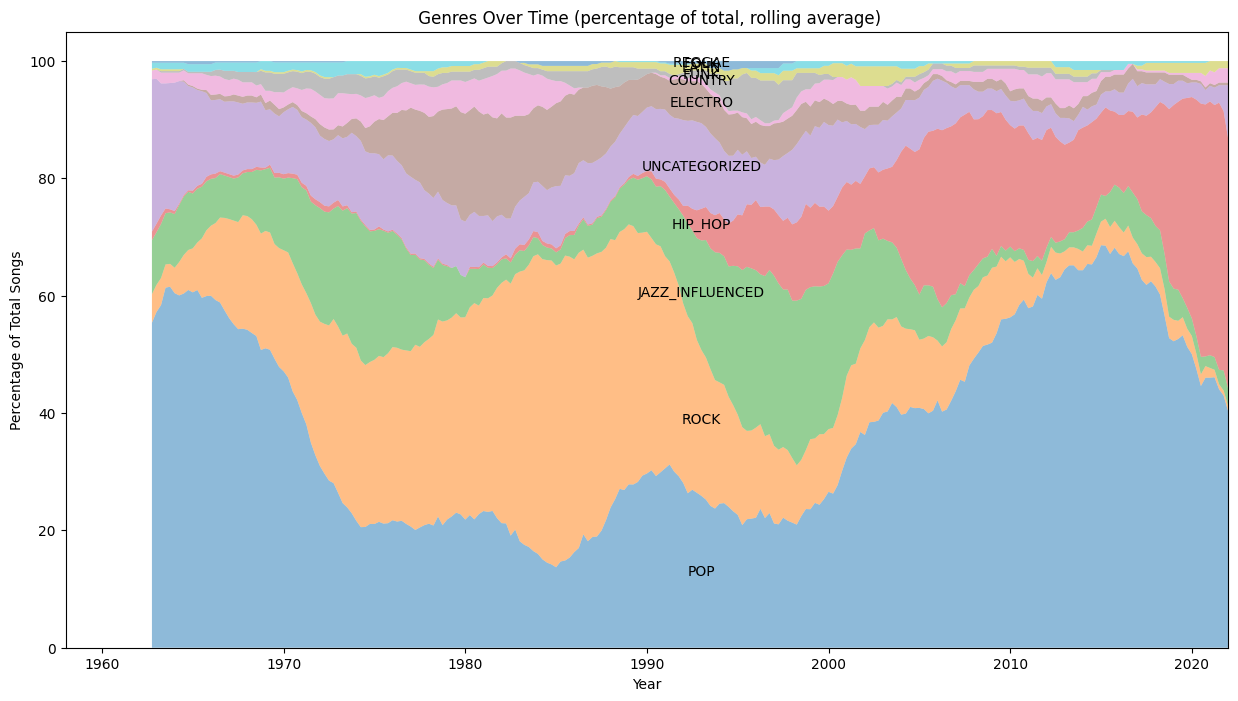

In [59]:
def stacked_genres_over_time(df, title_prepend=''):
    # Group by generic_genre and then calculate the count for each 0.25 interval in date_as_decimal
    grouped_df = df.groupby(['generic_genre', (df['date_as_decimal']*4).astype(int)/4]).size().reset_index(name='count')
    grouped_df.rename(columns={'date_as_decimal': 'quarterly_decimal'}, inplace=True)

    # Pivot the DataFrame so that generic_genre becomes the columns, the date is the index, and the values are the counts
    pivoted_df = grouped_df.pivot(index='quarterly_decimal', columns='generic_genre', values='count').fillna(0)

    # Calculate the total number of songs for each quarterly interval
    quarterly_totals = pivoted_df.sum(axis=1)

    # Divide by the quarterly totals to get the percentages
    pivoted_df = pivoted_df.divide(quarterly_totals, axis=0) * 100

    # Apply a rolling mean with a window of size 2 to smooth over two quarters (i.e., 6 months)
    pivoted_df = pivoted_df.rolling(window=16).mean().dropna()

    # Sort the columns by their total sum to get the most popular genre on top
    sorted_columns = pivoted_df.sum().sort_values(ascending=False).index
    pivoted_df = pivoted_df[sorted_columns]

    # Create a stacked area plot with a unique color for each genre
    plt.figure(figsize=(15, 8))
    stack_coll = plt.stackplot(pivoted_df.index, pivoted_df.T, alpha=0.5)

    # Label the areas directly on the plot, centered within each area
    for i, genre in enumerate(pivoted_df.columns):
        y_offset = pivoted_df.iloc[:, :i].sum(axis=1).rolling(window=2).mean().dropna().values
        y_values = pivoted_df[genre].rolling(window=2).mean().dropna().values
        y_mid = y_offset + y_values / 2
        x_values = pivoted_df.index
        plt.text(x_values[len(x_values)//2], y_mid[len(y_mid)//2], genre, ha='center', va='center')

    plt.title(f'{title_prepend} Genres Over Time (percentage of total, rolling average)')
    plt.xlabel('Year')
    plt.xlim(1958, 2022) # Adjust these limits if your data has a different time range
    plt.ylabel('Percentage of Total Songs')
    plt.show()

stacked_genres_over_time(df)

In [60]:
df.generic_genre.value_counts()

generic_genre
POP                1862
ROCK               1072
UNCATEGORIZED       535
JAZZ_INFLUENCED     530
HIP_HOP             419
ELECTRO             254
COUNTRY             135
FUNK                 78
LATIN                44
FOLK                 40
REGGAE               11
Name: count, dtype: int64

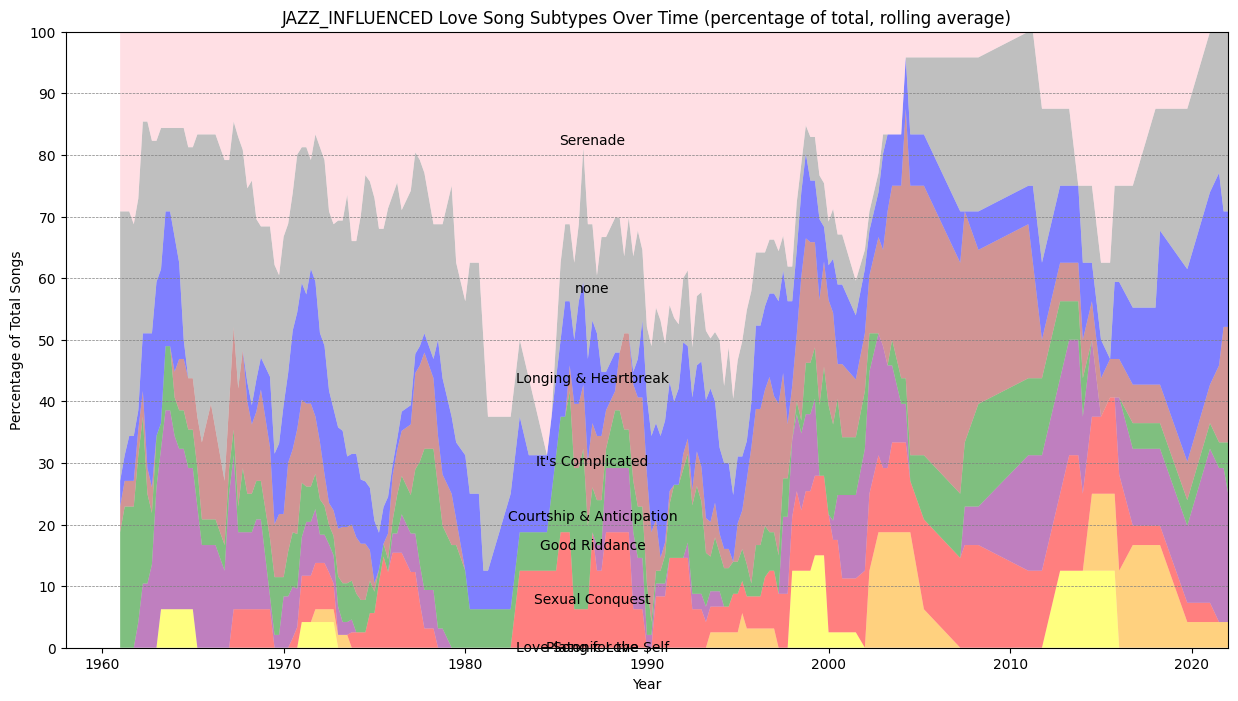

In [61]:
stacked_bars_over_time(df[df.generic_genre == 'JAZZ_INFLUENCED'], title_prepend='JAZZ_INFLUENCED')

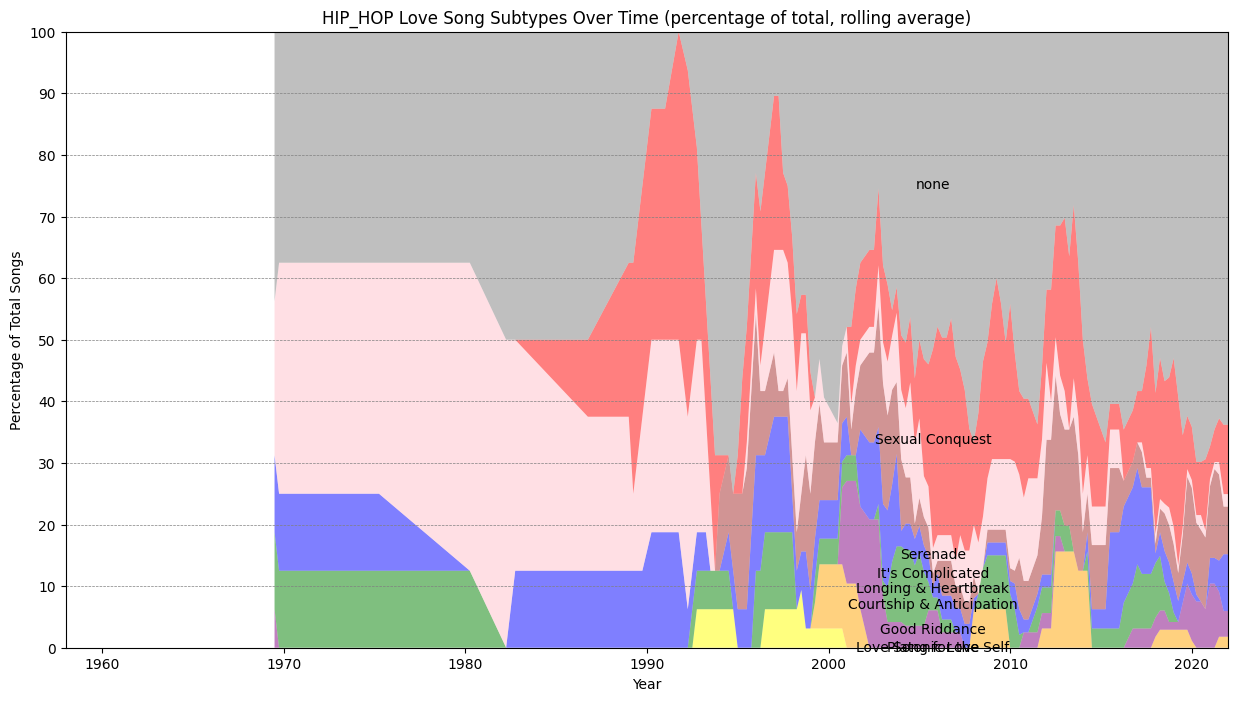

In [62]:
stacked_bars_over_time(df[df.generic_genre == 'HIP_HOP'], title_prepend='HIP_HOP')

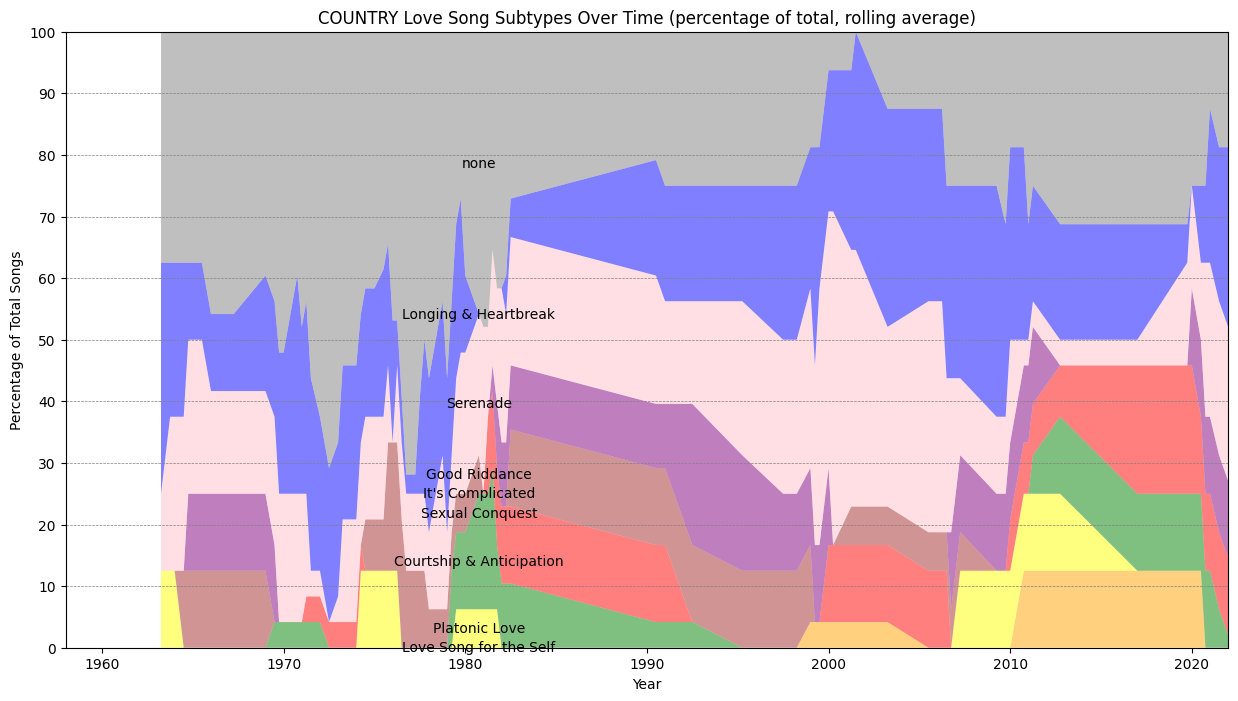

In [63]:
stacked_bars_over_time(df[df.generic_genre == 'COUNTRY'], title_prepend='COUNTRY')

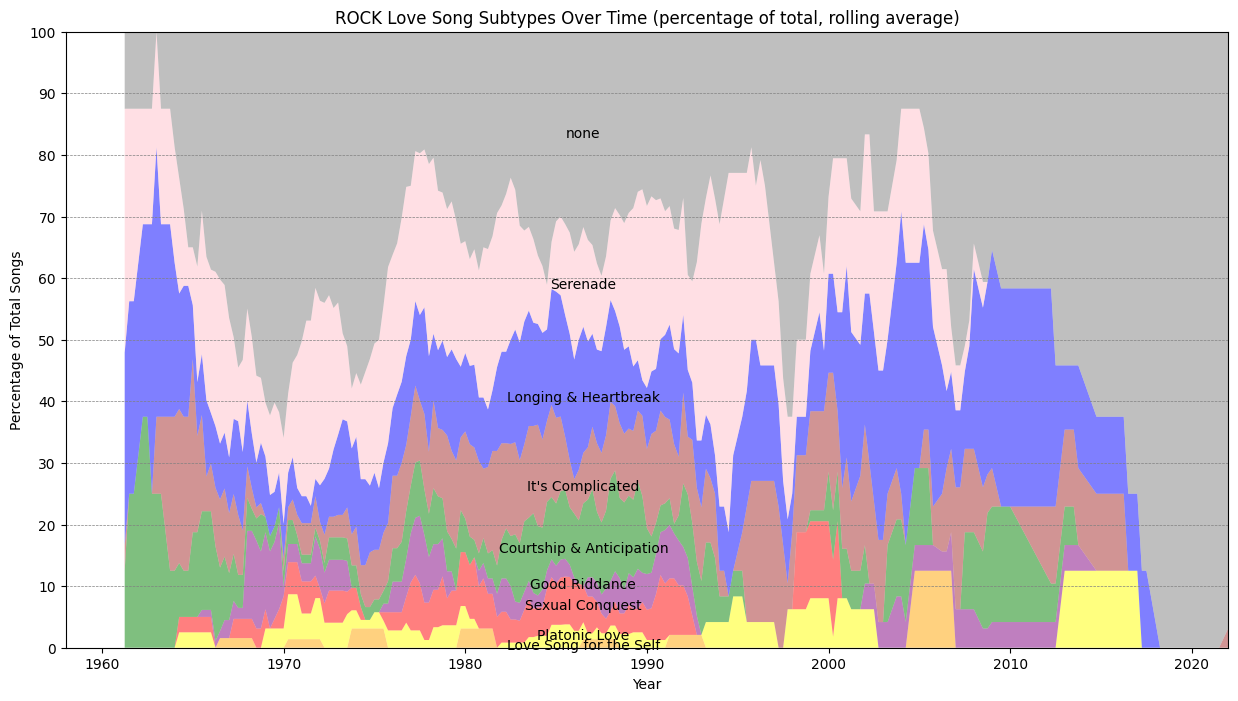

In [64]:
stacked_bars_over_time(df[df.generic_genre == 'ROCK'], title_prepend='ROCK')

# Comparing love song types over time

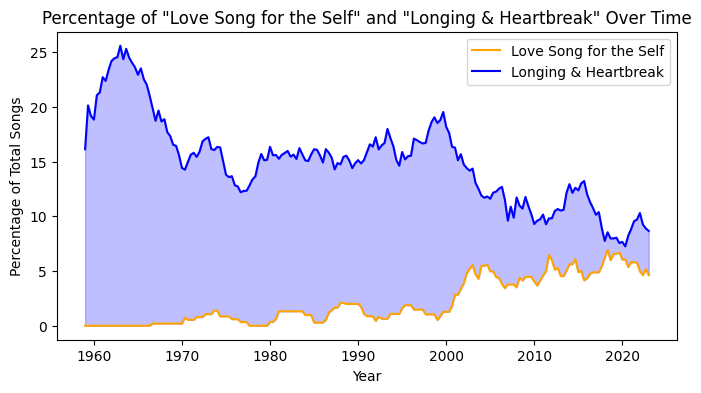

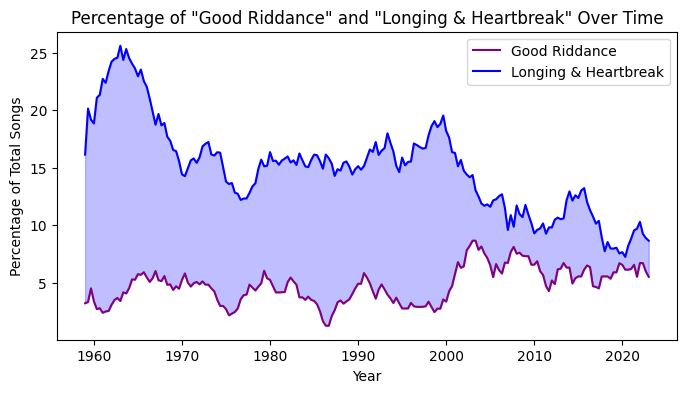

In [65]:
def plot_love_song_subtype_percentage(df, love_song_subtype1, love_song_subtype2, rolling_window=12):
    # Group by love_song_sub_type and date rounded to three-month intervals, and calculate the count for each
    grouped_df = df.groupby(['love_song_sub_type', (df['date_as_decimal']*3).round(0)/3]).size().reset_index(name='count')

    # Pivot to get subtypes as columns
    pivoted_df = grouped_df.pivot(index='date_as_decimal', columns='love_song_sub_type', values='count').fillna(0)

    # Calculate the total number of songs for each date interval
    total_songs = pivoted_df.sum(axis=1)

    # Normalize the counts of the selected subtypes to percentages of total songs
    rolling_subtype1_percentage = (pivoted_df[love_song_subtype1] / total_songs * 100).rolling(window=rolling_window, min_periods=1).mean()
    rolling_subtype2_percentage = (pivoted_df[love_song_subtype2] / total_songs * 100).rolling(window=rolling_window, min_periods=1).mean()

    # Get time values
    time = pivoted_df.index

    # Initialize figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot lines for the specified love song subtypes
    ax.plot(time, rolling_subtype1_percentage, color=COLOR_MAP[love_song_subtype1], label=love_song_subtype1)
    ax.plot(time, rolling_subtype2_percentage, color=COLOR_MAP[love_song_subtype2], label=love_song_subtype2)

    # Fill area when subtype1 > subtype2 with the color of subtype1
    ax.fill_between(time, rolling_subtype1_percentage, rolling_subtype2_percentage, where=(rolling_subtype1_percentage > rolling_subtype2_percentage), 
                    interpolate=True, color=COLOR_MAP[love_song_subtype1], alpha=0.25)

    # Fill area when subtype1 <= subtype2 with the color of subtype2
    ax.fill_between(time, rolling_subtype1_percentage, rolling_subtype2_percentage, where=(rolling_subtype1_percentage <= rolling_subtype2_percentage), 
                    interpolate=True, color=COLOR_MAP[love_song_subtype2], alpha=0.25)

    ax.set_title(f'Percentage of "{love_song_subtype1}" and "{love_song_subtype2}" Over Time')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of Total Songs')
    ax.legend()
    plt.show()



plot_love_song_subtype_percentage(
    df,
    'Love Song for the Self',
    'Longing & Heartbreak'
)


plot_love_song_subtype_percentage(
    df,
    'Good Riddance',
    'Longing & Heartbreak'
)

# Gender percentages over time:

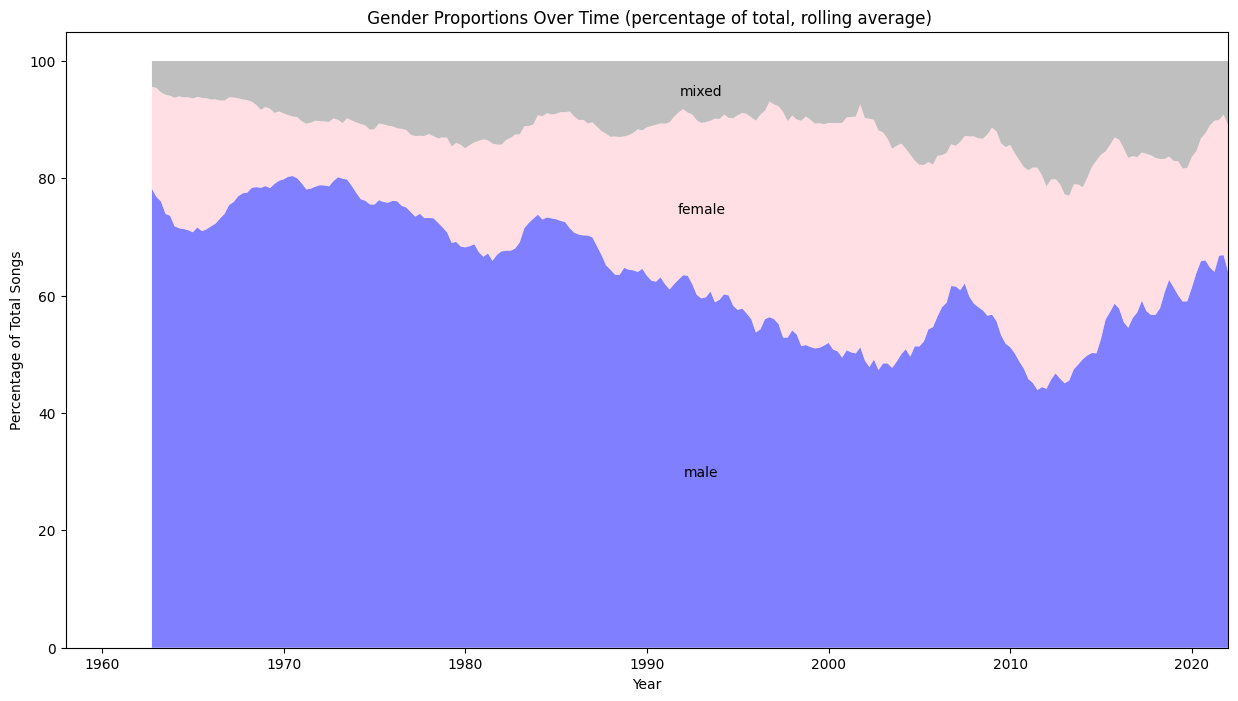

In [66]:
GENDER_COLOR_MAP = {
    'm': 'blue',
    'f': 'pink',
    'x': 'gray',
}

GENDER_LABELS = {
    'm': 'male',
    'f': 'female',
    'x': 'mixed',
}

def gender_stacked_areas_over_time(df, genders_to_include=['m', 'f', 'x'], title_prepend=''):
    # Group by gender and then calculate the count for each 0.25 interval in date_as_decimal
    grouped_df = df.groupby(['gender', (df['date_as_decimal']*4).astype(int)/4]).size().reset_index(name='count')
    grouped_df.rename(columns={'date_as_decimal': 'quarterly_decimal'}, inplace=True)

    # Pivot the DataFrame so that gender becomes the columns, the date is the index, and the values are the counts
    pivoted_df = grouped_df.pivot(index='quarterly_decimal', columns='gender', values='count').fillna(0)

    # Calculate the total number of songs for each quarterly interval
    quarterly_totals = pivoted_df.sum(axis=1)

    # Divide by the quarterly totals to get the percentages
    pivoted_df = pivoted_df.divide(quarterly_totals, axis=0) * 100

    # Apply a rolling mean with a window of size 2 to smooth over two quarters (i.e., 6 months)
    pivoted_df = pivoted_df.rolling(window=16).mean().dropna()

    # Filter the columns based on the genders_to_include
    pivoted_df = pivoted_df[genders_to_include]

    # Define the colors for the areas based on the sorted columns
    colors = [GENDER_COLOR_MAP[gender] for gender in genders_to_include]

    # Create a stacked area plot with the specified colors
    plt.figure(figsize=(15, 8))
    stack_coll = plt.stackplot(pivoted_df.index, pivoted_df.T, colors=colors, alpha=0.5)

    # Label the areas directly on the plot, centered within each area
    for i, gender in enumerate(genders_to_include):
        y_offset = pivoted_df.iloc[:, :i].sum(axis=1).rolling(window=2).mean().dropna().values
        y_values = pivoted_df[gender].rolling(window=2).mean().dropna().values
        y_mid = y_offset + y_values / 2
        x_values = pivoted_df.index
        plt.text(x_values[len(x_values)//2], y_mid[len(y_mid)//2], GENDER_LABELS[gender], ha='center', va='center')

    plt.title(f'{title_prepend} Gender Proportions Over Time (percentage of total, rolling average)')
    plt.xlabel('Year')
    plt.xlim(1958, 2022) # Adjust these limits if your data has a different time range
    plt.ylabel('Percentage of Total Songs')
    plt.show()



gender_stacked_areas_over_time(df)

# Comparing Percentage of Type by gender: pink shade means *women use it more*, blue means men do

In [67]:
def plot_gender_percentage(df, rolling_window=12):
    # Group by gender and date rounded to four-month intervals, and calculate the total songs for each gender
    total_gender_count_df = df.groupby(['gender', (df['date_as_decimal']*3).round(0)/3]).size().reset_index(name='count')

    # Pivot to get gender as columns
    pivoted_df = total_gender_count_df.pivot(index='date_as_decimal', columns='gender', values='count').fillna(0)

    # Calculate the percentage
    pivoted_df['f_percentage'] = (pivoted_df['f'] / (pivoted_df['f'] + pivoted_df['m'])) * 100
    pivoted_df['m_percentage'] = (pivoted_df['m'] / (pivoted_df['f'] + pivoted_df['m'])) * 100

    # Apply rolling mean to smooth the lines
    rolling_female_percentage = pivoted_df['f_percentage'].rolling(window=rolling_window, min_periods=1).mean()
    rolling_male_percentage = pivoted_df['m_percentage'].rolling(window=rolling_window, min_periods=1).mean()

    # Get time values
    time = pivoted_df.index

    # Initialize figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot lines for female and male
    ax.plot(time, rolling_female_percentage, color="pink", label="Female")
    ax.plot(time, rolling_male_percentage, color="blue", label="Male")

    # Fill area when female > male with pink
    ax.fill_between(time, rolling_female_percentage, rolling_male_percentage, where=(rolling_female_percentage > rolling_male_percentage), 
                    interpolate=True, color="pink", alpha=0.25)

    # Fill area when female <= male with blue
    ax.fill_between(time, rolling_female_percentage, rolling_male_percentage, where=(rolling_female_percentage <= rolling_male_percentage), 
                    interpolate=True, color="blue", alpha=0.25)

    ax.set_title('Percentage of Songs for Each Gender Over Time')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of Songs')
    ax.legend()
    plt.show()


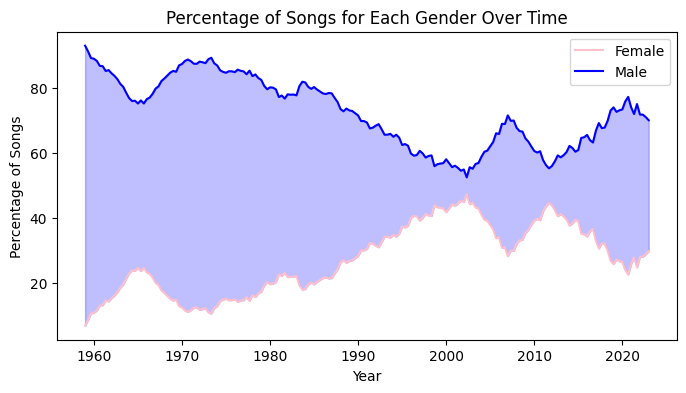

In [68]:
plot_gender_percentage(df)

In [69]:
def plot_gender_percentage(df, love_song_type, rolling_window=12):
    # Filter the DataFrame for the specified love song subtype
    filtered_df = df[df['love_song_sub_type'] == love_song_type]

    # Group by gender and date rounded to four-month intervals, and calculate the count for each
    grouped_count_df = filtered_df.groupby(['gender', (filtered_df['date_as_decimal']*3).round(0)/3]).size().reset_index(name='count')

    # Group by gender and date rounded to four-month intervals, and calculate the total songs for each gender
    total_gender_count_df = df.groupby(['gender', (df['date_as_decimal']*3).round(0)/3]).size().reset_index(name='total_count')

    # Merge the count and total count DataFrames
    merged_df = grouped_count_df.merge(total_gender_count_df, on=['gender', 'date_as_decimal'])

    # Calculate the percentage
    merged_df['percentage'] = (merged_df['count'] / merged_df['total_count']) * 100

    # Pivot to get gender as columns
    pivoted_df = merged_df.pivot(index='date_as_decimal', columns='gender', values='percentage').fillna(0)

    # Apply rolling mean to smooth the lines
    rolling_female_percentage = pivoted_df['f'].rolling(window=rolling_window, min_periods=1).mean()
    rolling_male_percentage = pivoted_df['m'].rolling(window=rolling_window, min_periods=1).mean()

    # Get time values
    time = pivoted_df.index

    # Initialize figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot lines for female and male
    ax.plot(time, rolling_female_percentage, color="pink", label="Female")
    ax.plot(time, rolling_male_percentage, color="blue", label="Male")

    # Fill area when female > male with pink
    ax.fill_between(time, rolling_female_percentage, rolling_male_percentage, where=(rolling_female_percentage > rolling_male_percentage), 
                    interpolate=True, color="pink", alpha=0.25)

    # Fill area when female <= male with blue
    ax.fill_between(time, rolling_female_percentage, rolling_male_percentage, where=(rolling_female_percentage <= rolling_male_percentage), 
                    interpolate=True, color="blue", alpha=0.25)

    ax.set_title(f'Percentage of {love_song_type} for Each Gender Over Time')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of Songs')
    ax.legend()
    plt.show()


In [70]:
def plot_gender_count(df, love_song_type, rolling_window=12):
    # Filter the DataFrame for the specified love song subtype
    filtered_df = df[df['love_song_sub_type'] == love_song_type]

    # Group by gender and date rounded to four-month intervals, and calculate the count for each
    grouped_count_df = filtered_df.groupby(['gender', (filtered_df['date_as_decimal']*3).round(0)/3]).size().reset_index(name='count')

    # Pivot to get gender as columns
    pivoted_df = grouped_count_df.pivot(index='date_as_decimal', columns='gender', values='count').fillna(0)

    # Apply rolling mean to smooth the lines
    rolling_female_count = pivoted_df['f'].rolling(window=rolling_window, min_periods=1).mean()
    rolling_male_count = pivoted_df['m'].rolling(window=rolling_window, min_periods=1).mean()

    # Get time values
    time = pivoted_df.index

    # Initialize figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot lines for female and male
    ax.plot(time, rolling_female_count, color="pink", label="Female")
    ax.plot(time, rolling_male_count, color="blue", label="Male")

    # Fill area when female > male with pink
    ax.fill_between(time, rolling_female_count, rolling_male_count, where=(rolling_female_count > rolling_male_count), 
                    interpolate=True, color="pink", alpha=0.25)

    # Fill area when female <= male with blue
    ax.fill_between(time, rolling_female_count, rolling_male_count, where=(rolling_female_count <= rolling_male_count), 
                    interpolate=True, color="blue", alpha=0.25)

    ax.set_title(f'Count of {love_song_type} for Each Gender Over Time')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count of Songs')
    ax.legend()
    plt.show()


In [71]:
df.love_song_sub_type.value_counts()

love_song_sub_type
none                        1590
Serenade                    1020
Longing & Heartbreak         763
It's Complicated             442
Courtship & Anticipation     434
Sexual Conquest              312
Good Riddance                233
Platonic Love                 98
Love Song for the Self        88
Name: count, dtype: int64

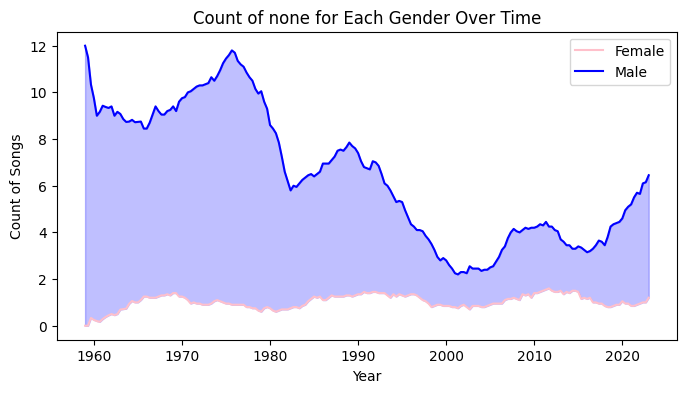

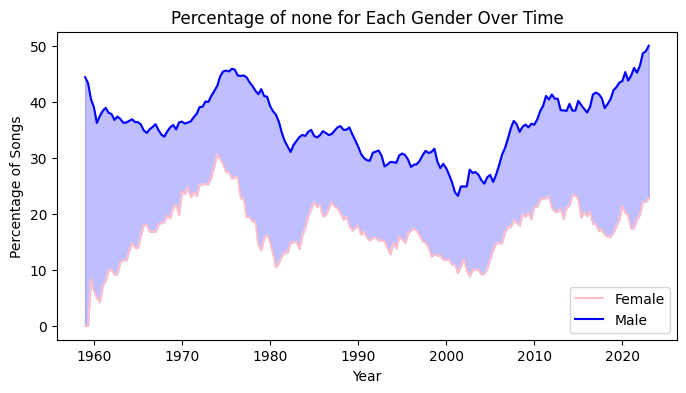

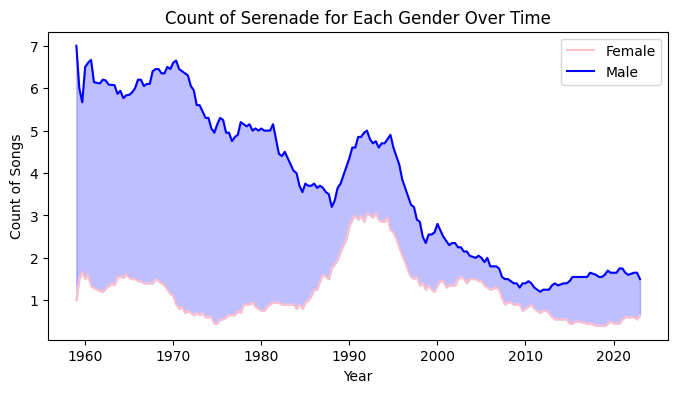

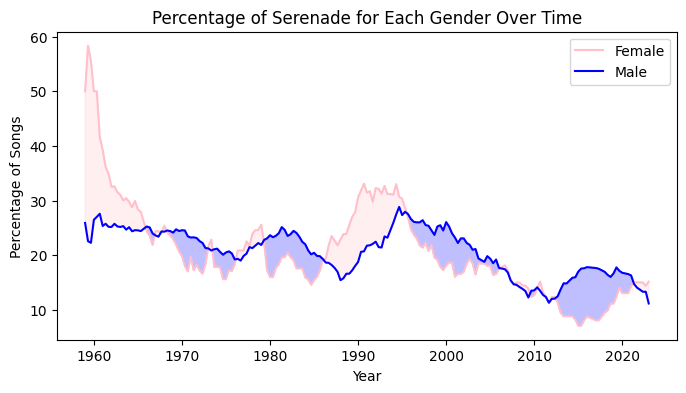

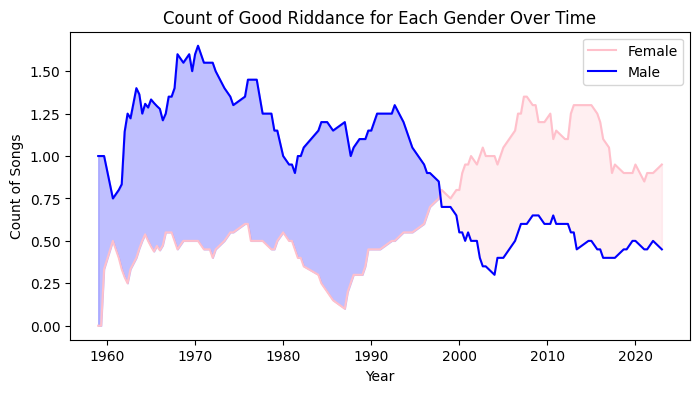

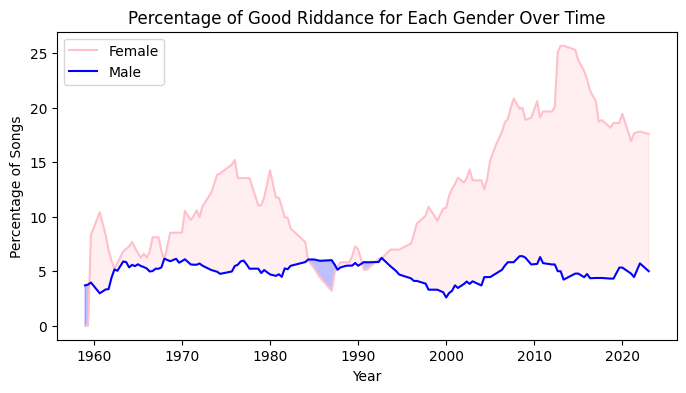

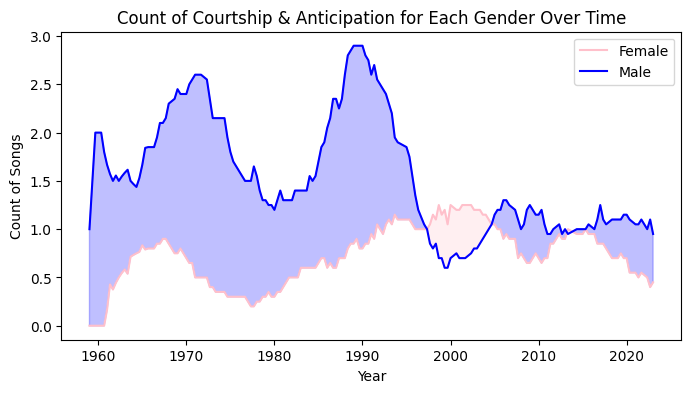

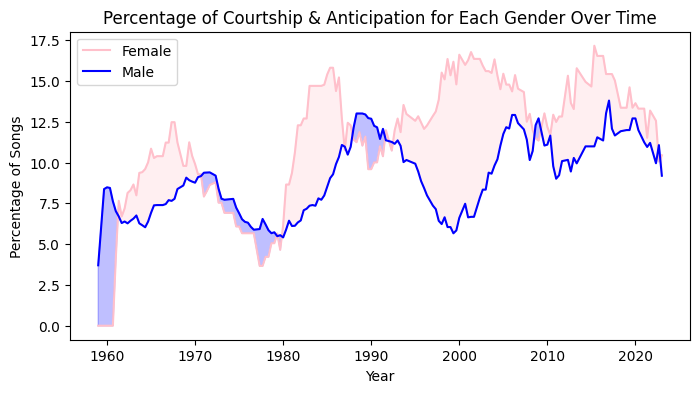

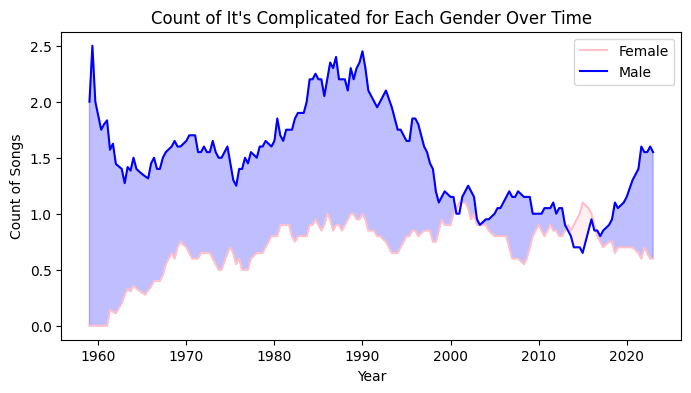

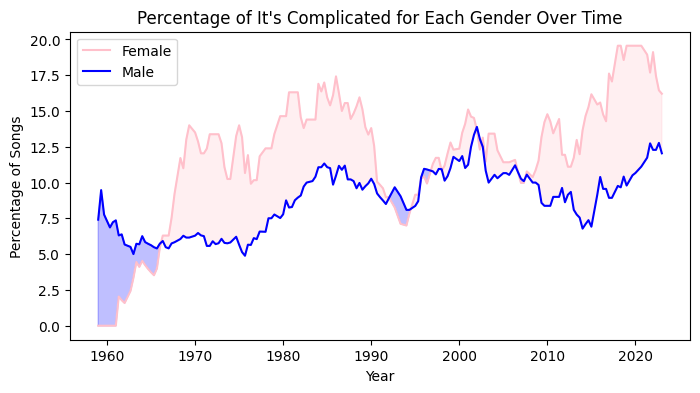

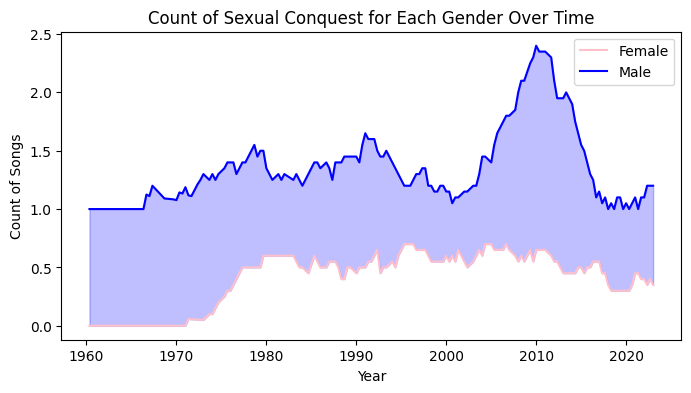

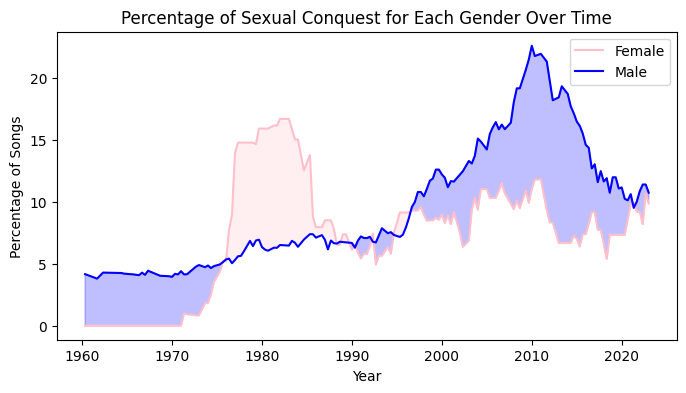

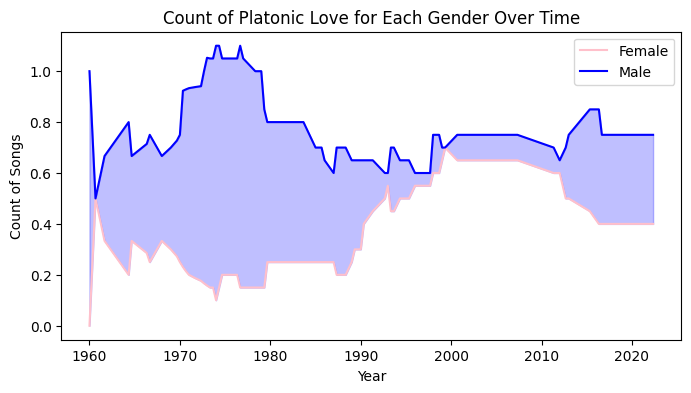

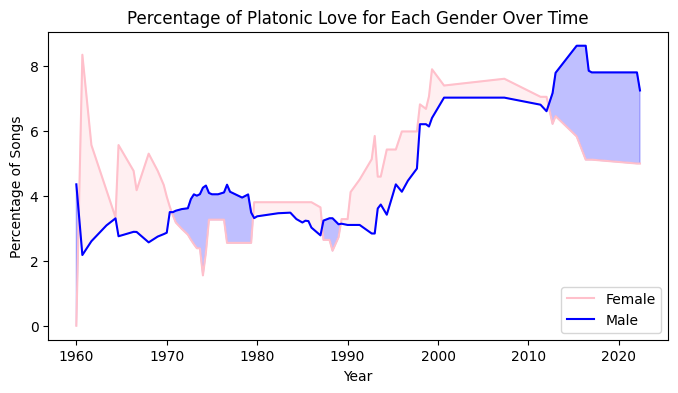

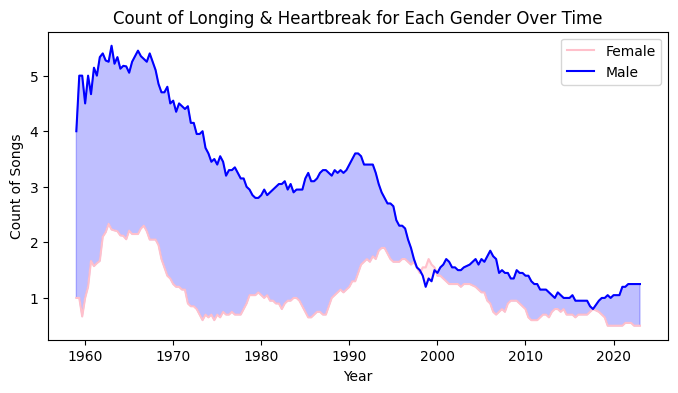

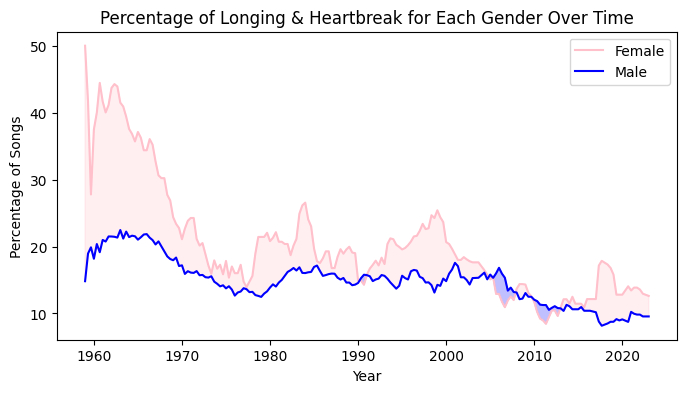

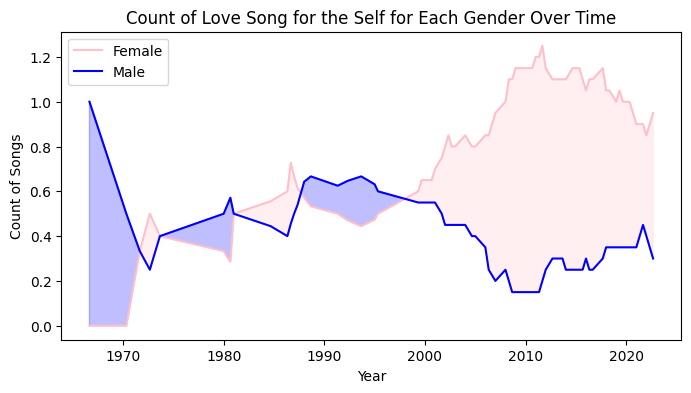

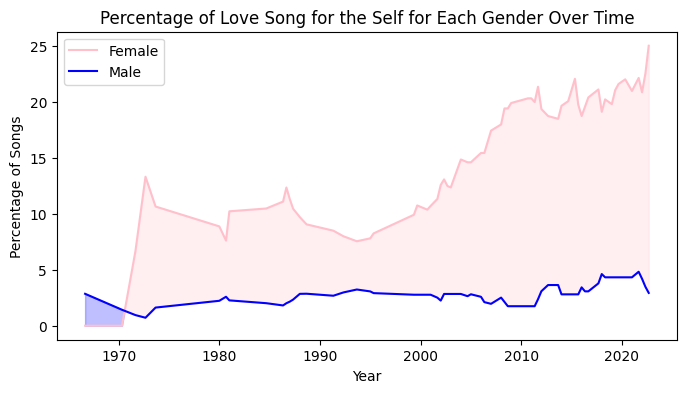

In [72]:

for subtype in LOVE_SONG_SUB_TYPES:
    rolling_window = 20
    plot_gender_count(df, subtype, rolling_window=rolling_window)
    plot_gender_percentage(df, subtype, rolling_window=rolling_window)

# "Music these days isn't even music": comparing trends to the average from a particular period of time

In [73]:
def plot_subtype_trend_vs_average(df, love_song_type, average_comparison_line_date_range=[1958, 1969], rolling_window=2):
    # Filter the DataFrame for the specified love song subtype
    filtered_df = df[df['love_song_sub_type'] == love_song_type]

    # Group by date rounded to four-month intervals, and calculate the count for each
    grouped_count_df = filtered_df.groupby((filtered_df['date_as_decimal']*3).round(0)/3).size().reset_index(name='count')

    # Group by date rounded to four-month intervals, and calculate the total songs
    total_count_df = df.groupby((df['date_as_decimal']*3).round(0)/3).size().reset_index(name='total_count')

    # Merge the count and total count DataFrames
    merged_df = grouped_count_df.merge(total_count_df, on='date_as_decimal', how='right').fillna(0)

    # Calculate the percentage
    merged_df['percentage'] = (merged_df['count'] / merged_df['total_count']) * 100

    # Apply rolling mean to smooth the line
    rolling_percentage = merged_df['percentage'].rolling(window=rolling_window, min_periods=1).mean()

    # Filter the DataFrame to the specified date range and calculate the average percentage
    average_percentage = merged_df[(merged_df['date_as_decimal'] >= average_comparison_line_date_range[0]) &
                                   (merged_df['date_as_decimal'] <= average_comparison_line_date_range[1])]['percentage'].mean()

    # Get time values
    time = merged_df['date_as_decimal']

    # Initialize figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot line for the trend
    ax.plot(time, rolling_percentage, color="black", label="Trend")

    # Add horizontal line for the average
    ax.axhline(y=average_percentage, color='gray', linestyle='--', label="Average")

    # Fill area when trend > average with blue
    ax.fill_between(time, rolling_percentage, average_percentage, where=(rolling_percentage > average_percentage), 
                    interpolate=True, color="blue", alpha=0.25)

    # Fill area when trend <= average with red
    ax.fill_between(time, rolling_percentage, average_percentage, where=(rolling_percentage <= average_percentage), 
                    interpolate=True, color="red", alpha=0.25)

    ax.set_title(f'Trend of "{love_song_type}" Over Time vs. Average for {average_comparison_line_date_range}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of Songs')
    ax.legend()
    plt.show()


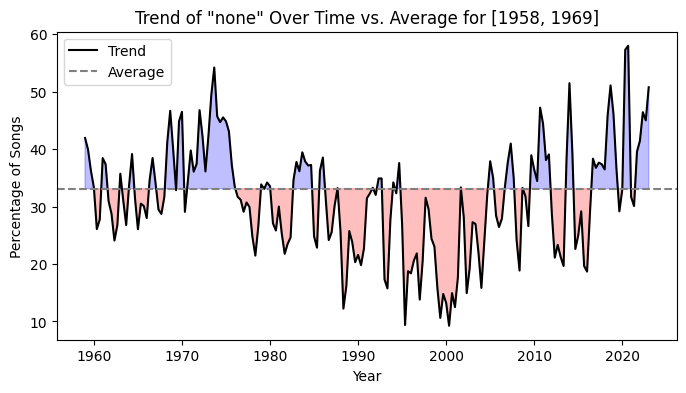

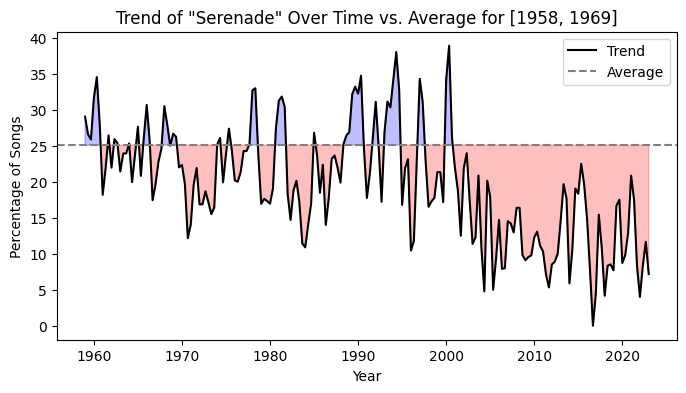

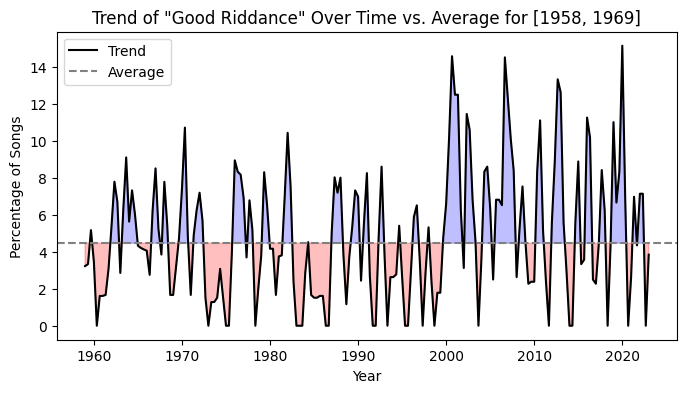

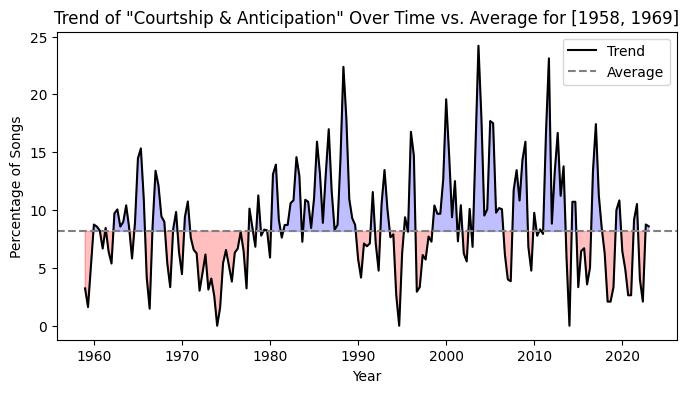

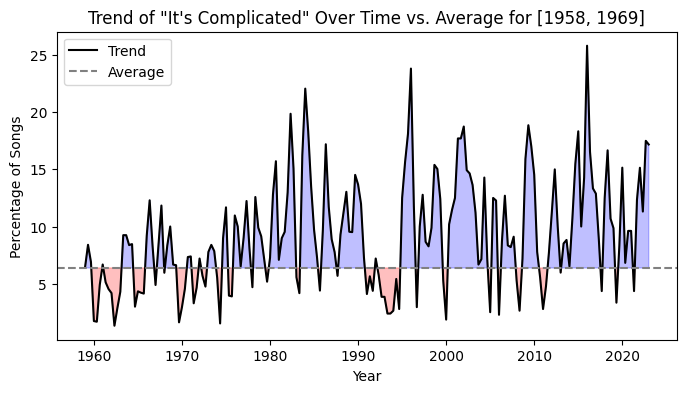

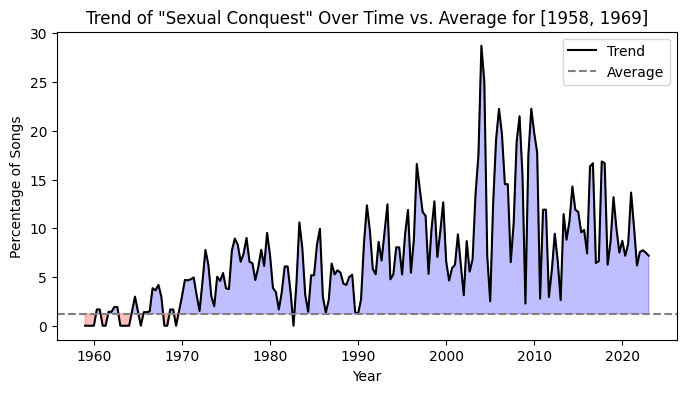

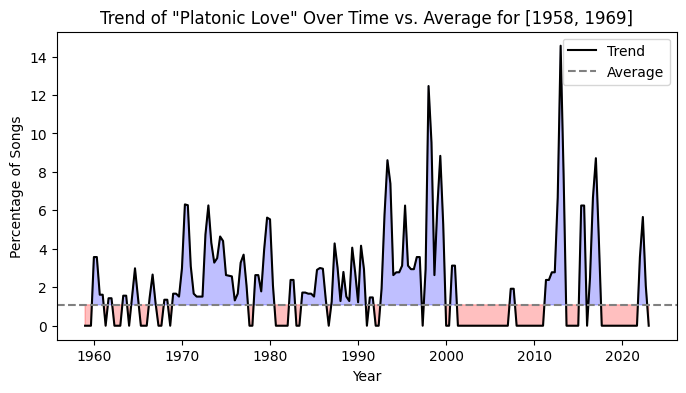

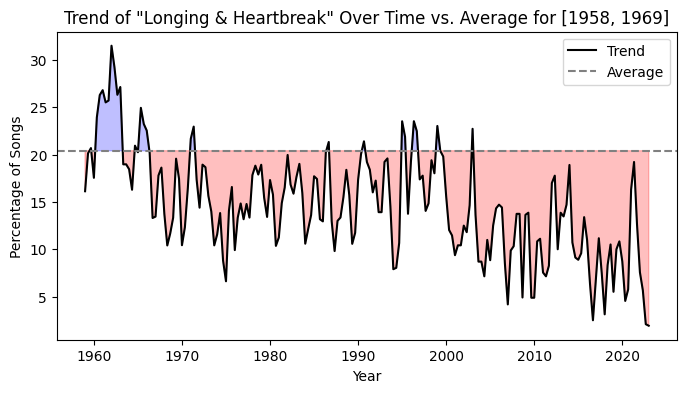

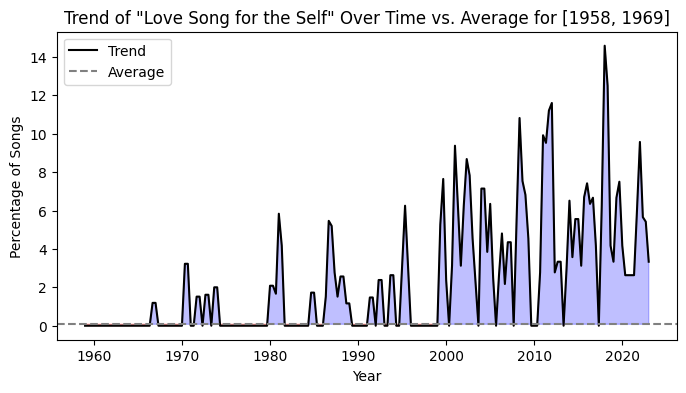

In [74]:
for subtype in LOVE_SONG_SUB_TYPES:
    plot_subtype_trend_vs_average(df, subtype, [1958, 1969])

# Look at artists

In [75]:
for subtype in LOVE_SONG_SUB_TYPES:
    # Filter the DataFrame to include only the specified subtype
    subtype_df = df[df['love_song_sub_type']==subtype]

    # Group by artist, then count the occurrences and sort 
    artist_counts = subtype_df.groupby('performer').size().sort_values(ascending=False)

    # Print the top 5 artists for each subtype with their counts
    top_artists = artist_counts.head(5)
    print(f"Top 5 artists for subtype '{subtype}':")
    print(top_artists)

    # Compute percentages
    total_songs_by_top_artists = df[df['performer'].isin(top_artists.index)].groupby('performer').size()
    percentages = (top_artists / total_songs_by_top_artists) * 100

    print("\nPercentage of total songs by these artists that belong to this subtype:")
    print(percentages)
    print("\n")

Top 5 artists for subtype 'none':
performer
The Beatles        16
Eminem             12
Michael Jackson    12
Stevie Wonder      12
Drake              11
dtype: int64

Percentage of total songs by these artists that belong to this subtype:
performer
Drake               50.000000
Eminem             100.000000
Michael Jackson     50.000000
Stevie Wonder       48.000000
The Beatles         48.484848
dtype: float64


Top 5 artists for subtype 'Serenade':
performer
Madonna          9
Chicago          9
Stevie Wonder    9
Neil Sedaka      6
The Beatles      6
dtype: int64

Percentage of total songs by these artists that belong to this subtype:
performer
Chicago          45.000000
Madonna          25.714286
Neil Sedaka      75.000000
Stevie Wonder    36.000000
The Beatles      18.181818
dtype: float64


Top 5 artists for subtype 'Good Riddance':
performer
Kelly Clarkson    5
P!nk              4
Mariah Carey      3
Taylor Swift      3
Bobby Vee         3
dtype: int64

Percentage of total songs

# Top artists

In [77]:
df

performer  \
0            "Weird Al" Yankovic   
1                        'N Sync   
2                        'N Sync   
3                        'N Sync   
4                        'N Sync   
...                          ...   
4975             matchbox twenty   
4976           twenty one pilots   
4977           twenty one pilots   
4978           twenty one pilots   
4979  will.i.am & Britney Spears   

                                                 song generic_genre  \
0                                       White & Nerdy          ROCK   
1     (God Must Have Spent) A Little More Time On You           POP   
2                                         Bye Bye Bye           POP   
3                                    It's Gonna Be Me           POP   
4                                  This I Promise You           POP   
...                                               ...           ...   
4975                                           Unwell          ROCK   
4976                                         Heathens          ROCK   
4977                                             Ride          ROCK   
4978                                     Stressed Out          ROCK   
4979                                   Scream & Shout           POP   

                                             lyric_line chart_debut  \
0                      They see me mowin' my front lawn  2006-10-14   
1                                               Yeah...  1998-12-05   
2                                              Hey, hey  2000-01-29   
3                                    (It's gonna be me)  2000-05-06   
4                                           Oh oh oh oh  2000-09-30   
...                                                 ...         ...   
4975                                            All day  2003-03-22   
4976  All my friends are heathens, take it slow (In ...  2016-07-09   
4977          I just wanna stay in the sun where I find  2016-04-02   
4978  I wish I found some better sounds no one's eve...  2015-05-16   
4979                                   Bring the action  2012-12-15   

              x          y  chart_debut_date_normalized_0_to_1  \
0     50.912490  44.870985                              74.845   
1     81.288336  39.382591                              62.655   
2     71.402847  30.184848                              64.441   
3     68.789522  53.089582                              64.860   
4     74.214520  30.421922                              65.481   
...         ...        ...                                 ...   
4975  56.149341  35.176103                              69.317   
4976  58.202752  54.398868                              89.969   
4977  48.387025  35.286120                              89.550   
4978  60.782772  37.133766                              88.183   
4979  50.209962  46.394865                              84.441   

      genre_position_band  near_neighbors_count gender  date_as_decimal  \
0                    10.0                     0      m       2006.90080   
1                     0.0                    12      m       1999.09920   
2                     0.0                    14      m       2000.24224   
3                     0.0                     0      m       2000.51040   
4                     0.0                    14      m       2000.90784   
...                   ...                   ...    ...              ...   
4975                 10.0                     7      m       2003.36288   
4976                 10.0                     0      m       2016.58016   
4977                 10.0                     1      m       2016.31200   
4978                 10.0                     1      m       2015.43712   
4979                  0.0                     1      x       2013.04224   

                                          justification  \
0     a parody about nerd culture and stereotypes, n...   
1     expressing how special and perfect his love in...   
2     a song 

In [112]:
# Check for missing gender values
missing_gender = df['gender'].isnull().sum()
print(f"Number of missing gender values: {missing_gender}")

# Check for unique gender values
unique_gender_values = df['gender'].unique()
print(f"Unique gender values: {unique_gender_values}")

Number of missing gender values: 0
Unique gender values: ['m' 'x' 'f']


In [137]:
# Get count of each love song sub-type for each performer
song_counts = pd.crosstab(df['primary_performer'], df['love_song_sub_type'])

# Get total song count for each performer
total_song_counts = df['primary_performer'].value_counts()

# Combine these into one dataframe
agg_df = pd.concat([total_song_counts, song_counts], axis=1, sort=False)

# Fill NaNs with 0 (these occur where a performer has no songs of a given type)
agg_df = agg_df.fillna(0)
# reset index so that primary_performer is a column
# agg_df = agg_df.reset_index

# # Calculate percentages of total for each love song sub-type
for sub_type in LOVE_SONG_SUB_TYPES:
    agg_df[f'{sub_type}_pct'] = round(agg_df[sub_type] / agg_df['count'] * 100)

# # Maintain the existing "gender" column
most_common_gender = df.groupby('primary_performer')['gender'].agg(lambda x:x.value_counts().index[0])

# join in the most common gender to agg_df
agg_df = agg_df.join(most_common_gender, on='primary_performer')

# # Select top 50 artists by total song count
top_artists_df = agg_df.nlargest(50, 'count')
top_artists_df = top_artists_df.reset_index()

In [138]:
def top_50_artist_stacked_bars(top_artists_df, sort_by='Serenade'):
    # Sort by the percentage of the given song type
    top_artists_df = top_artists_df.sort_values(by=f'{sort_by}_pct', ascending=False)

    # Reorder the columns based on LOVE_SONG_SUB_TYPES such that sort_by is first
    ordered_sub_types = [sort_by] + [sub_type for sub_type in LOVE_SONG_SUB_TYPES if sub_type != sort_by]
    percentage_columns = [f'{sub_type}_pct' for sub_type in ordered_sub_types]
    colors = [COLOR_MAP[sub_type] for sub_type in ordered_sub_types]

    # Plotting code
    top_artists_df[percentage_columns].plot(
        kind='barh',
        stacked=True,
        figsize=(15,10),
        color=colors  # Assigning the reordered colors
    )
    plt.legend(ordered_sub_types)
    plt.title(f'Love Song Subtype Percentages for Top 50 Artists, sorted by {sort_by}')
    plt.xlabel('Percentage')
    plt.ylabel('Artist')
    plt.gca().invert_yaxis() # This is to maintain the top artist at the top after sorting
    plt.show()


## Comparing breakdowns for each artist, sorted by top performers for different categories

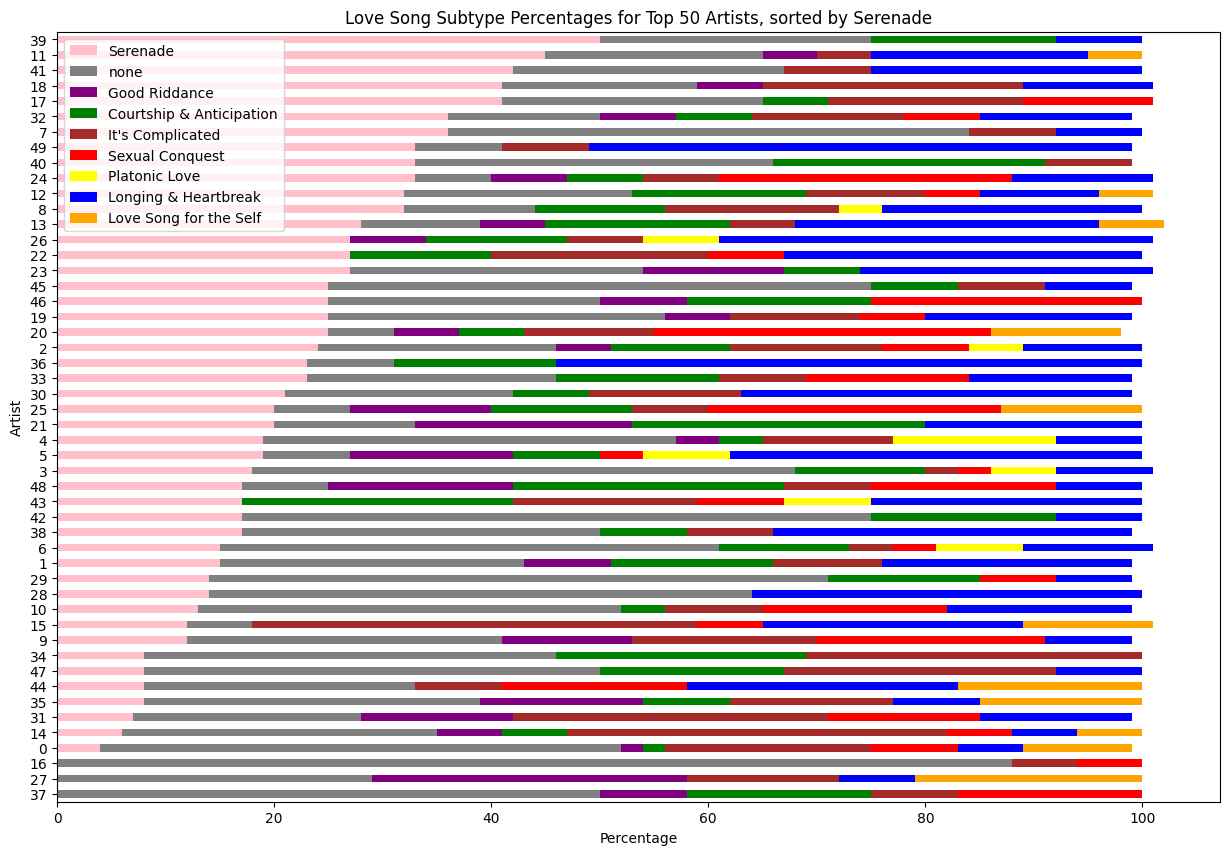

In [139]:
top_50_artist_stacked_bars(top_artists_df, sort_by='Serenade')

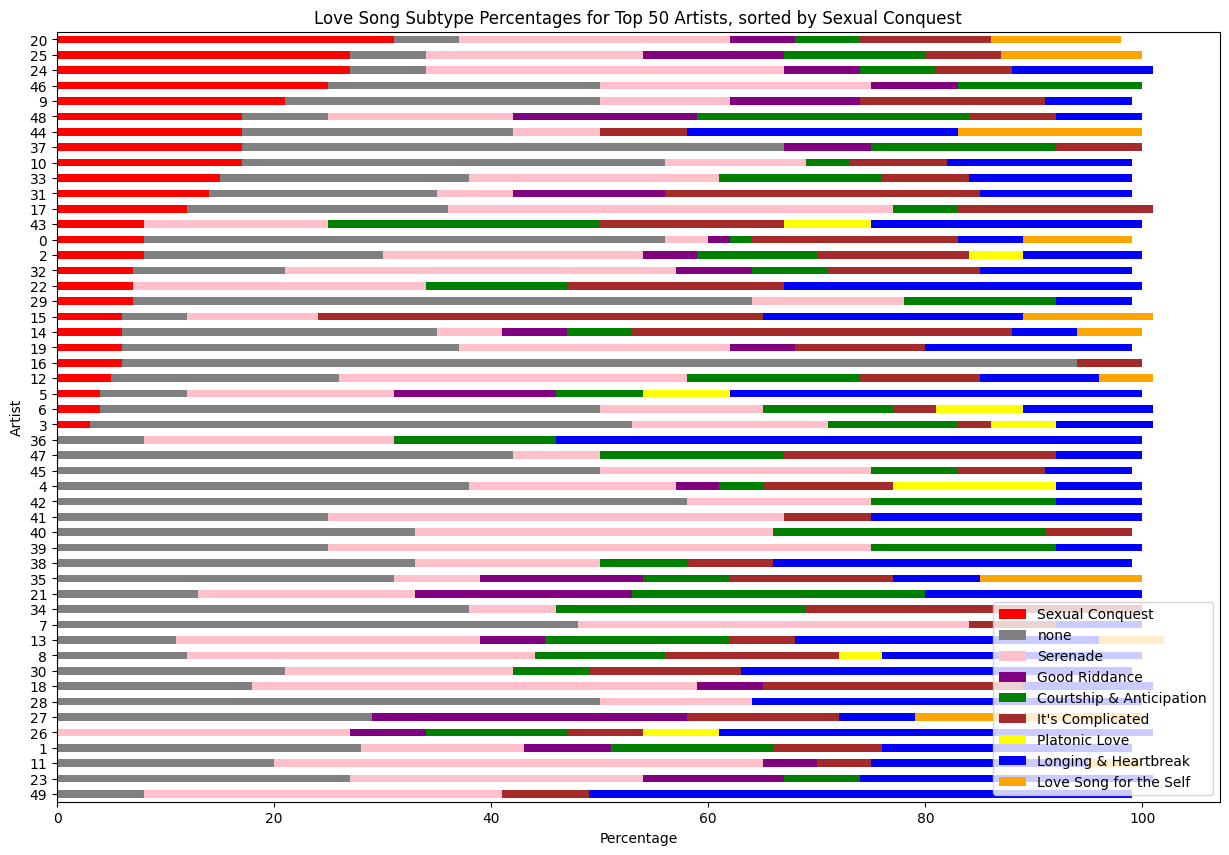

In [140]:
top_50_artist_stacked_bars(top_artists_df, sort_by='Sexual Conquest')

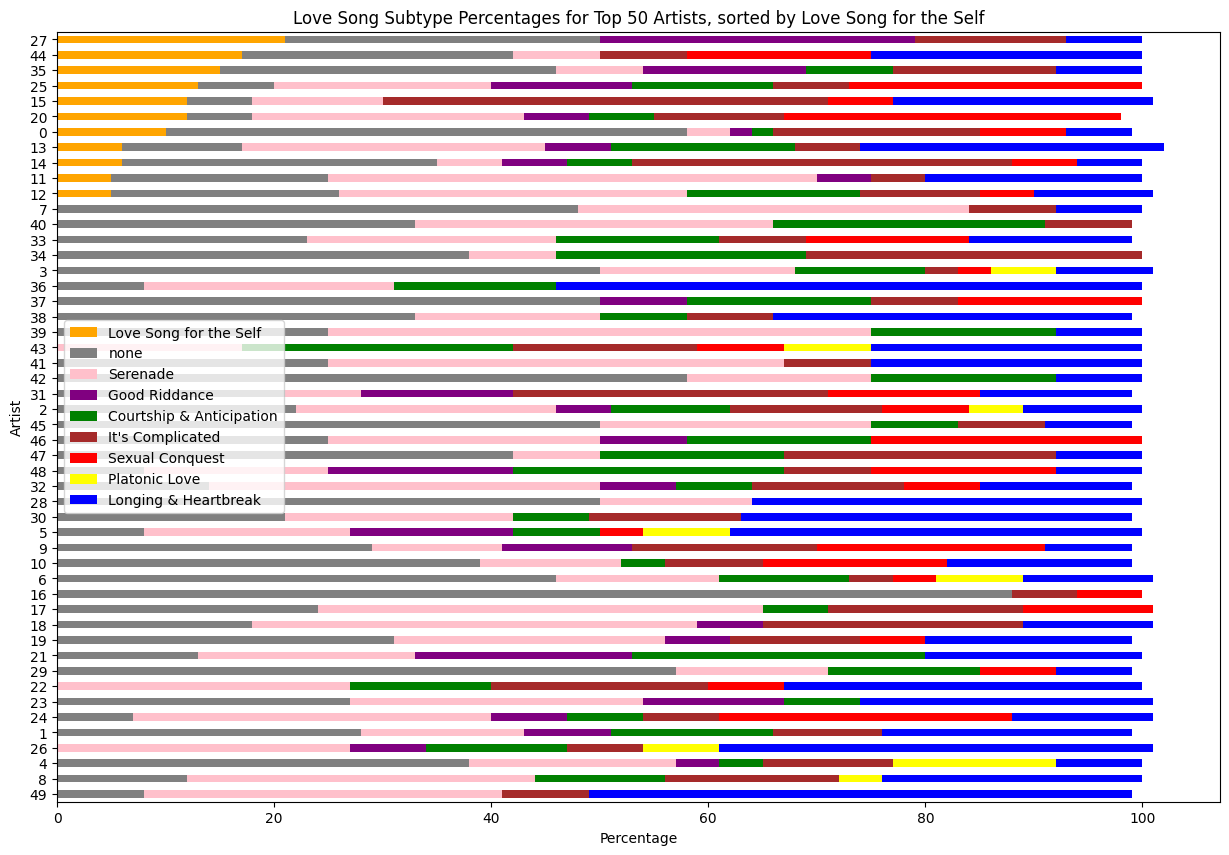

In [141]:
top_50_artist_stacked_bars(top_artists_df, sort_by='Love Song for the Self')

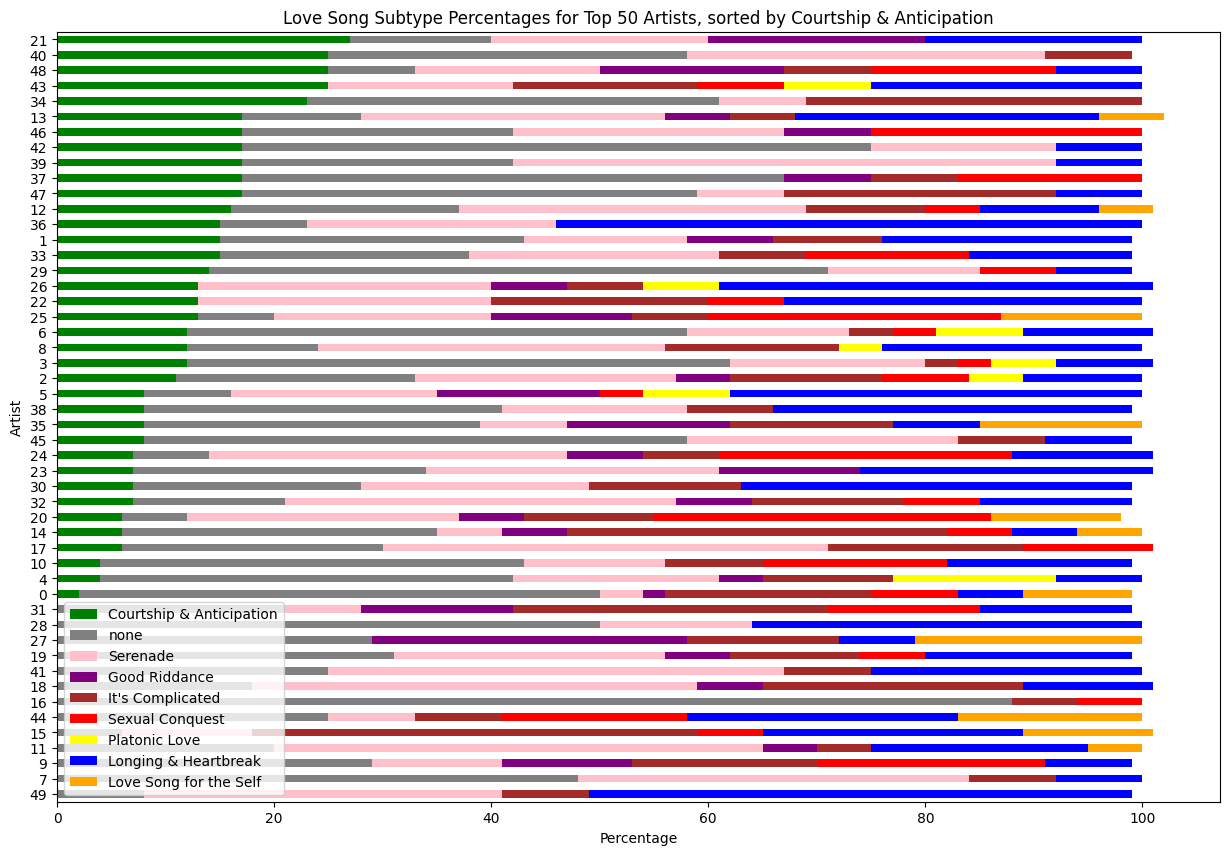

In [142]:
top_50_artist_stacked_bars(top_artists_df, sort_by='Courtship & Anticipation')

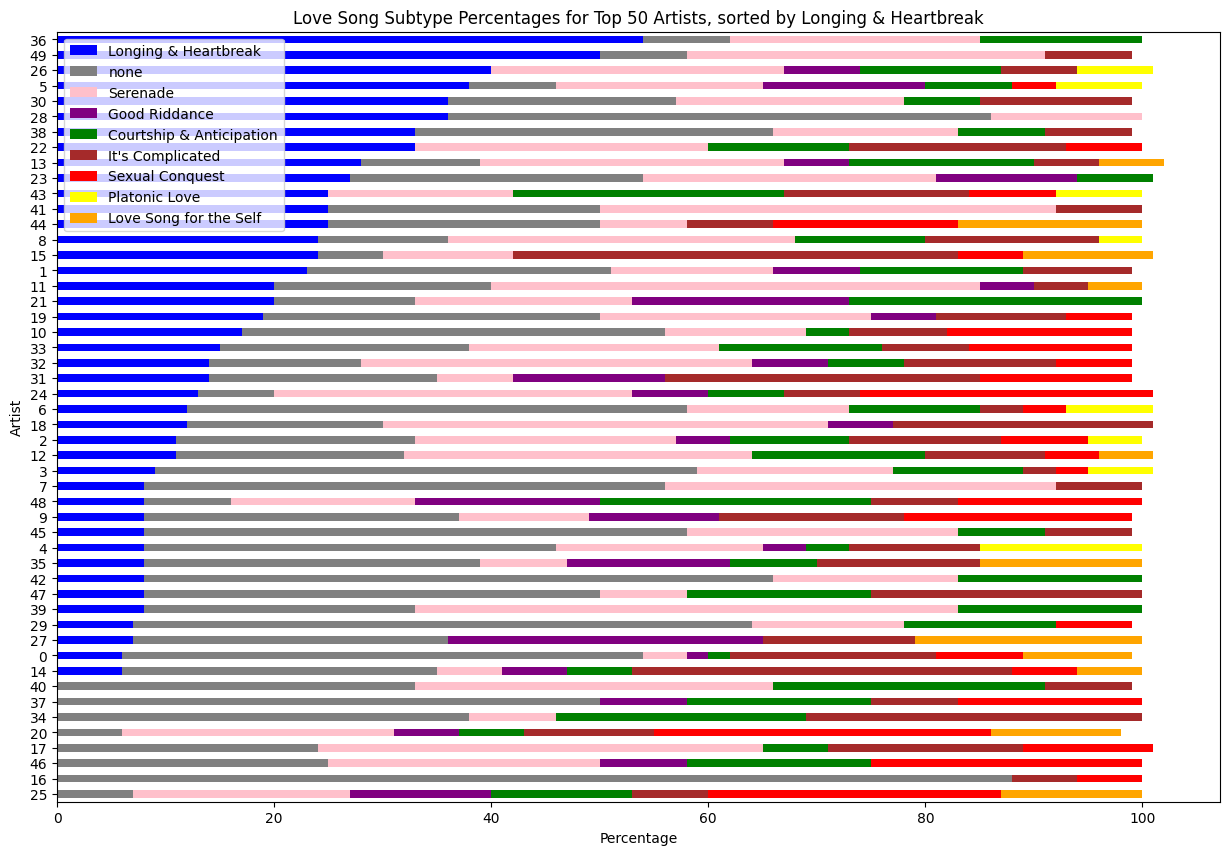

In [143]:
top_50_artist_stacked_bars(top_artists_df, sort_by='Longing & Heartbreak')

## Exploring archetypes: looking at correlations between 2 love song types

In [147]:
top_artists_df

primary_performer  count  Courtship & Anticipation  Good Riddance  \
0                   Drake     48                         1              1   
1            Taylor Swift     39                         6              3   
2                 Madonna     37                         4              2   
3             The Beatles     34                         4              0   
4              Elton John     26                         1              1   
5            Mariah Carey     26                         2              4   
6         Michael Jackson     26                         3              0   
7           Stevie Wonder     25                         0              0   
8           Elvis Presley     25                         3              0   
9                 Rihanna     24                         0              3   
10     The Rolling Stones     23                         1              0   
11                Chicago     20                         0              1   
12          Janet Jackson     19                         3              0   
13        Whitney Houston     18                         3              1   
14              Lady Gaga     17                         1              1   
15             Diana Ross     17                         0              0   
16                 Eminem     17                         0              0   
17            Marvin Gaye     17                         1              0   
18        Aretha Franklin     17                         0              1   
19  Daryl Hall John Oates     16                         0              1   
20          Ariana Grande     16                         1              1   
21          The 4 Seasons     15                         4              3   
22               Maroon 5     15                         2              0   
23               Bee Gees     15                         1              2   
24            Rod Stewart     15                         1              1   
25                Beyonce     15                         2              2   
26         Connie Francis     15                         2              1   
27                   P!nk     14                         0              4   
28        The Temptations     14                         0              0   
29         The Beach Boys     14                         2              0   
30           The Supremes     14                         1              0   
31                  Usher     14                         0              2   
32          Justin Bieber     14                         1              1   
33           Donna Summer     13                         2              0   
34             Billy Joel     13                         3              0   
35             Katy Perry     13                         1              2   
36             Brenda Lee     13                         2              0   
37              Lil Wayne     12                         2              1   
38           Phil Collins     12                         1              0   
39          Lionel Richie     12                         2              0   
40             Huey Lewis     12                         3              0   
41             Carpenters     12                         0              0   
42           Neil Diamond     12                         2              0   
43     Olivia Newton-John     12                         3              0   
44         George Michael     12                         0              0   
45                   Kool     12                         1              0   
46            Chris Brown     12                         2              1   
47      Bruce Springsteen     12                         2              0   
48      Justin Timberlake     12                         3              2   
49    The Everly Brothers     12                         0              0   

    It's Complicated  Longing & Heartbreak  Love Song for the Self  \
0         

In [158]:
def love_sogn_type_scatter_plot(top_artists_df, x, y):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Define color mapping
    colors = {'f': 'pink', 'm': 'blue', 'x': 'gray'}

    # Loop through the top_artists_df DataFrame
    for index, row in top_artists_df.iterrows():
        ax.scatter(row[f'{x}_pct'], row[f'{y}_pct'],
                   s=row['count'] * 10, # size based on total number of songs
                   c=colors[row['gender']], # color based on gender
                   label=row['primary_performer'], # label based on primary performer
                   alpha=0.6, edgecolors="w")

        # Add text label for each primary performer
        ax.text(row[f'{x}_pct'], row[f'{y}_pct'], row["primary_performer"], fontsize=9)

    ax.set_xlabel(f'"{x}" Percentage')
    ax.set_ylabel(f'"{y}" Percentage')
    ax.set_title(f'"{x}" vs "{y}" by Primary Performer')
    plt.show()

### "Thank you, next"

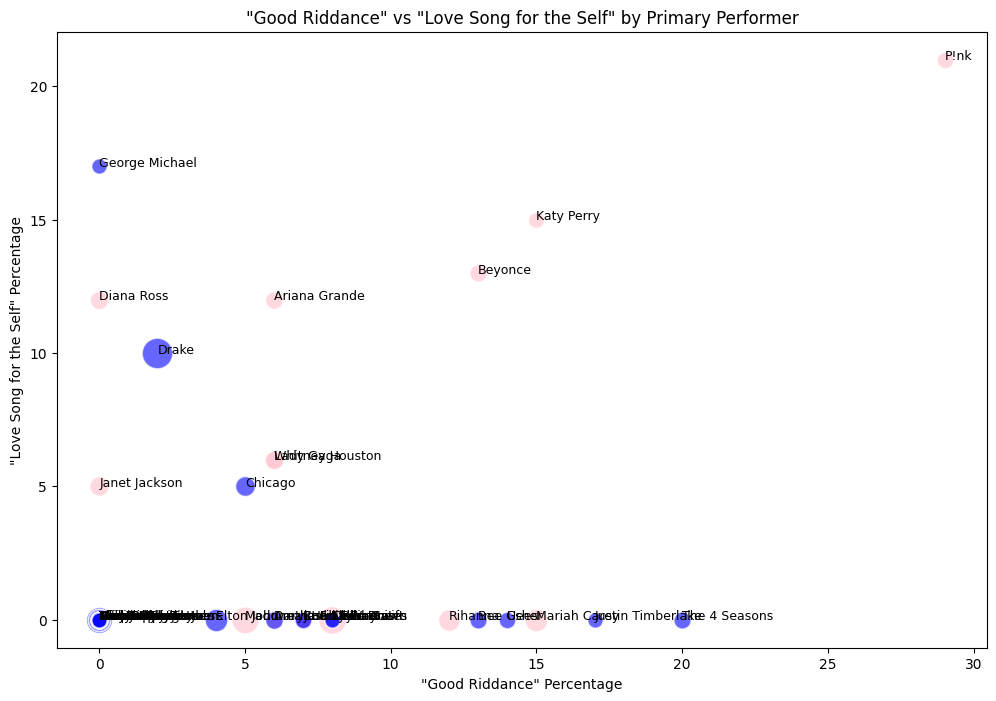

In [159]:
love_sogn_type_scatter_plot(top_artists_df, x='Good Riddance', y='Love Song for the Self')

### "Let's get physical (physical)": what kind of archetypes do we see that do a lot of Sexual Conquering?

#### "Sex & the ~City~ Self"

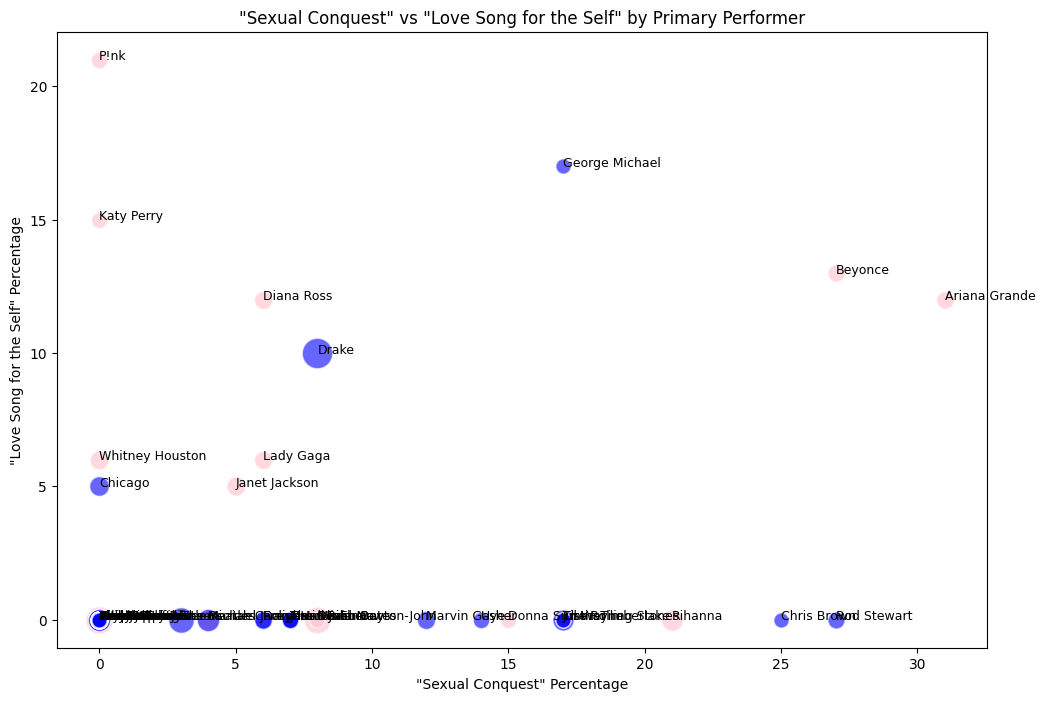

In [160]:
love_sogn_type_scatter_plot(top_artists_df, x='Sexual Conquest', y='Love Song for the Self')

#### "It's sex... or I'm not talking about romance." also the opposite: "It's sex... or it's romance-related"

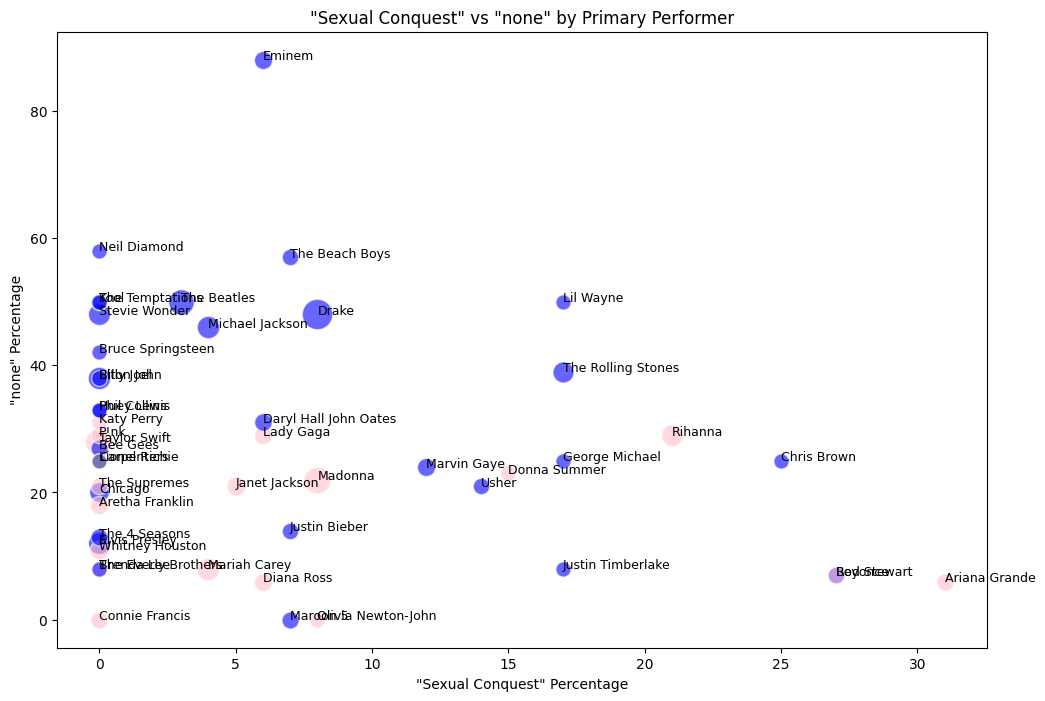

In [161]:
love_sogn_type_scatter_plot(top_artists_df, x='Sexual Conquest', y='none')

### Let's look at the Serenade's associations...

#### "Fall in love/bed"

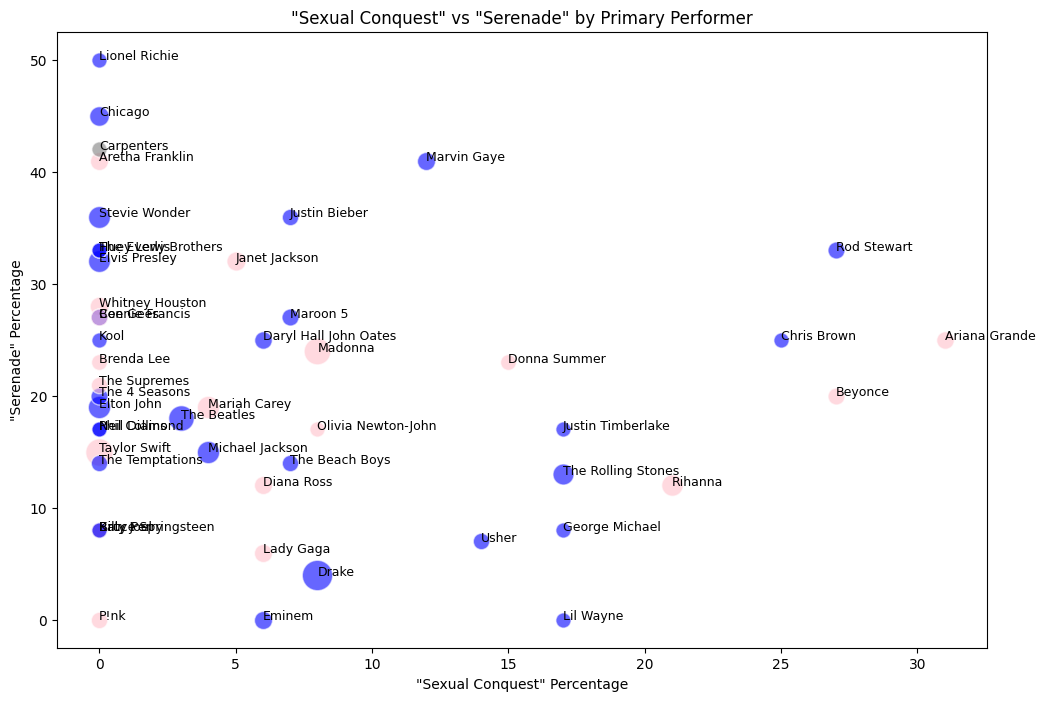

In [162]:
love_sogn_type_scatter_plot(top_artists_df, x='Sexual Conquest', y='Serenade')

#### "Highs... and lows"

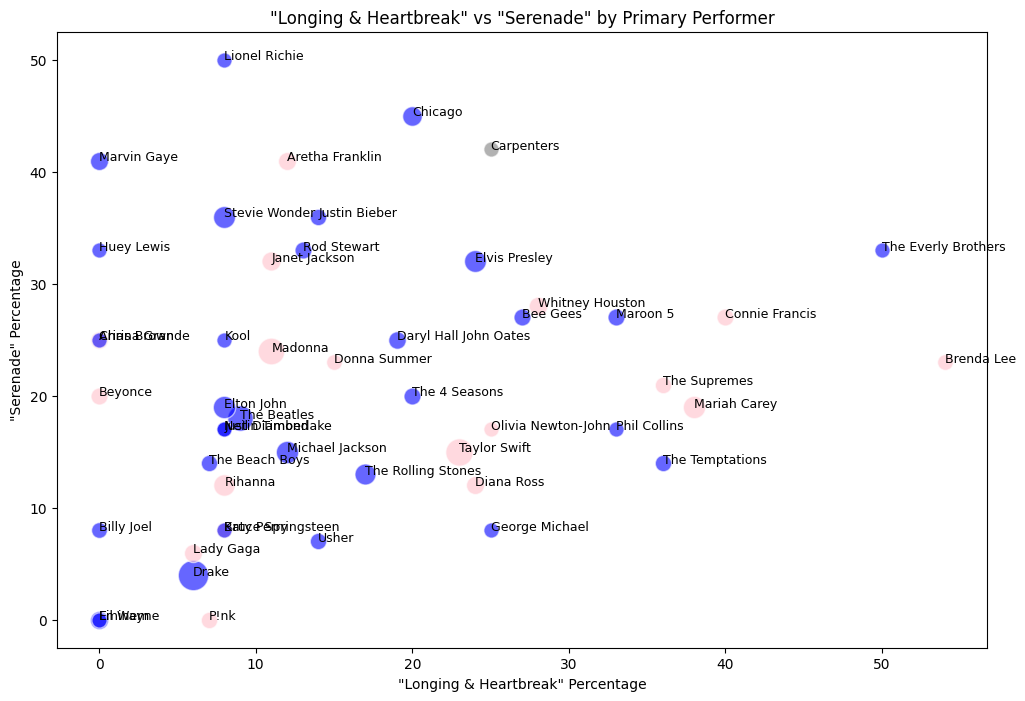

In [163]:
love_sogn_type_scatter_plot(top_artists_df, x='Longing & Heartbreak', y='Serenade')

### Antisipating... being let down

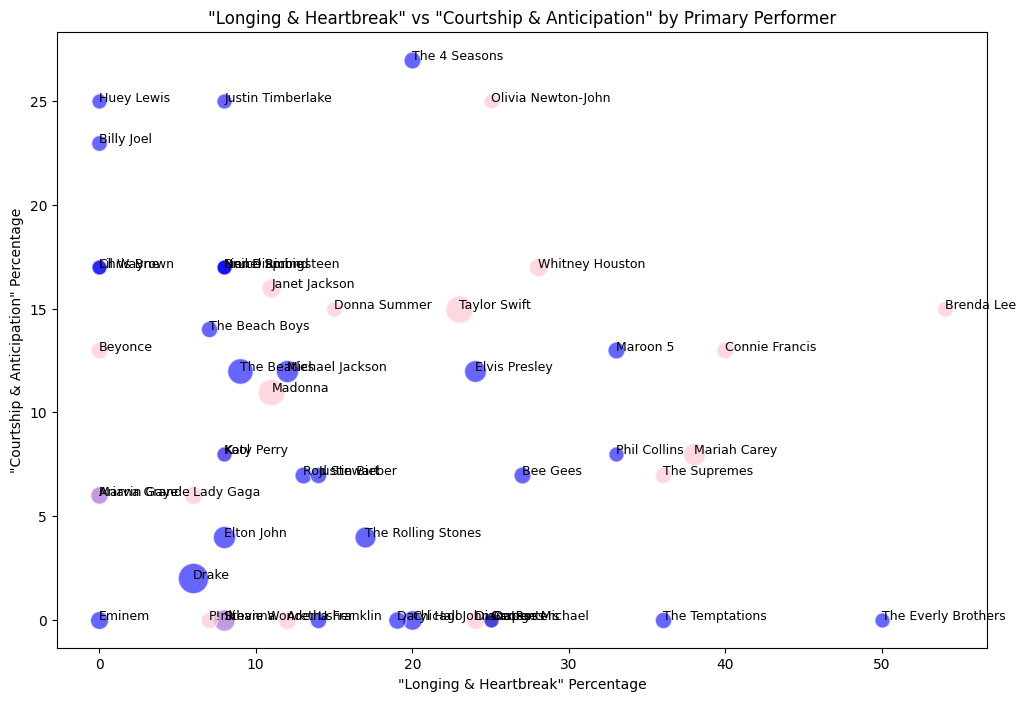

In [164]:
love_sogn_type_scatter_plot(top_artists_df, x='Longing & Heartbreak', y='Courtship & Anticipation')

### "Relationships, man..."

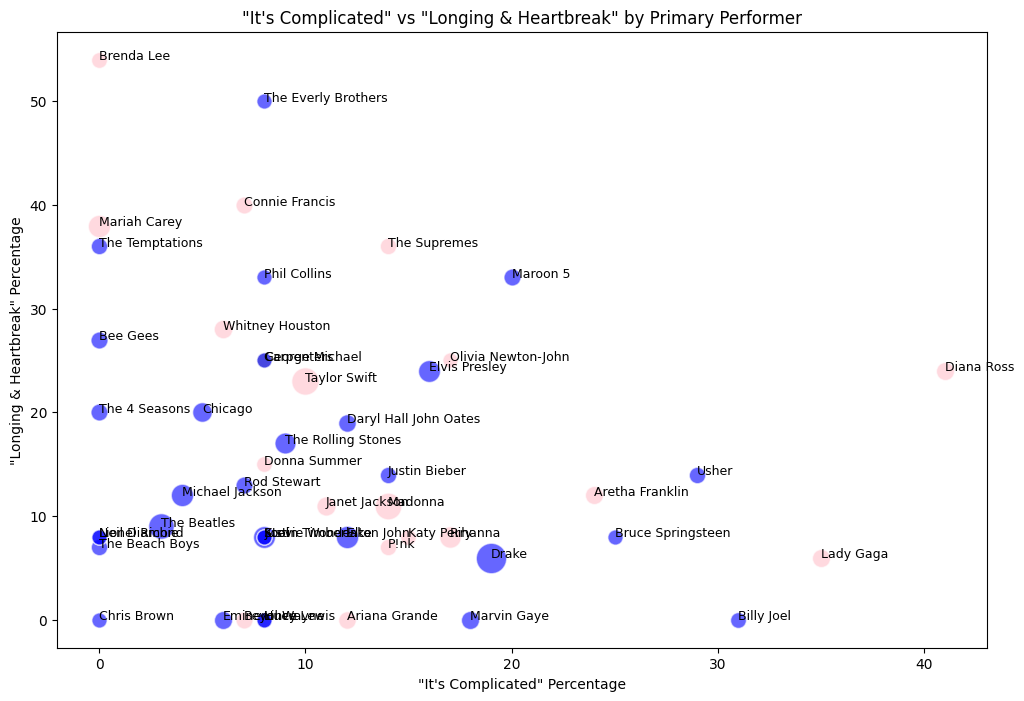

In [165]:
love_sogn_type_scatter_plot(top_artists_df, x="It's Complicated", y='Longing & Heartbreak')

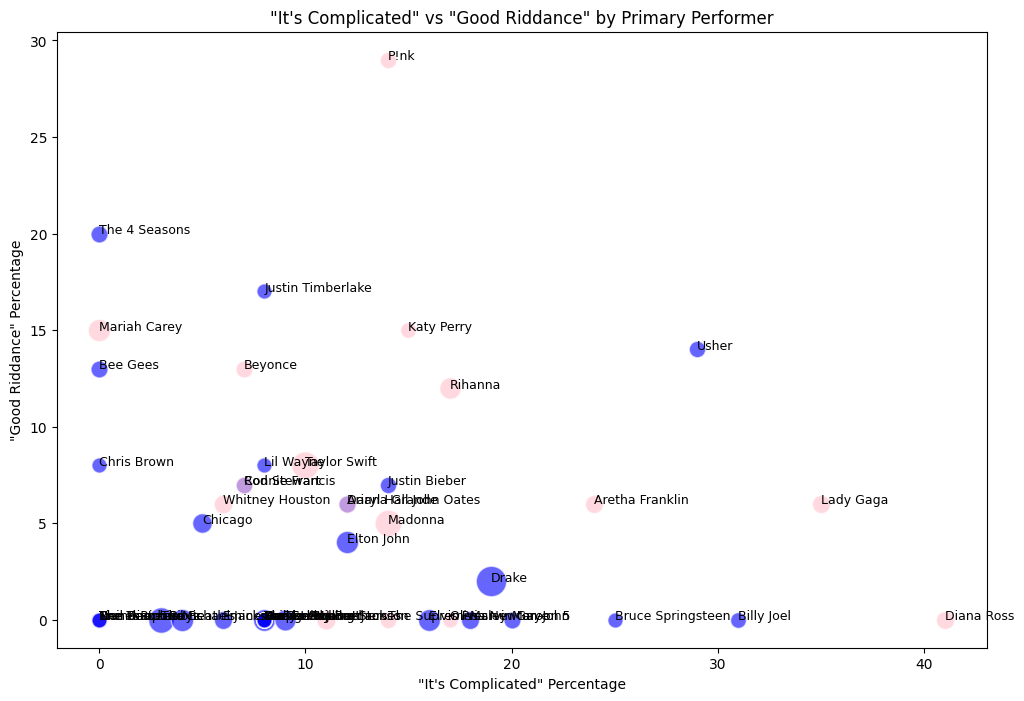

In [166]:
love_sogn_type_scatter_plot(top_artists_df, x="It's Complicated", y='Good Riddance')

### "(when you've transcended it all)" ... doesn't exist! Instead, we get "men wax platonic, women self-love"

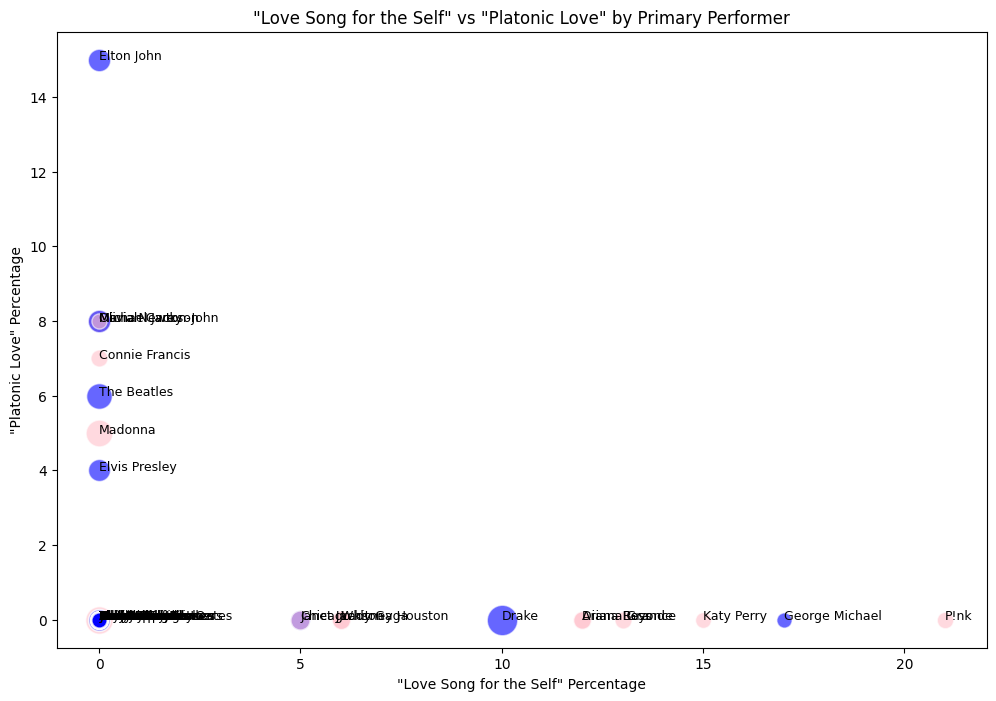

In [167]:
love_sogn_type_scatter_plot(top_artists_df, x="Love Song for the Self", y='Platonic Love')

# One hit wonders

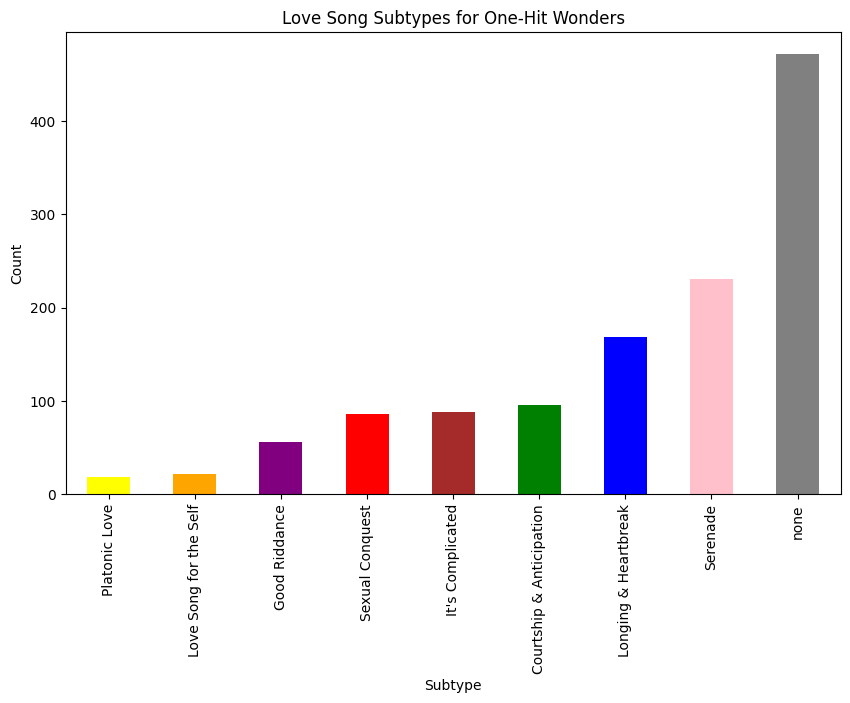

In [168]:
def one_hit_wonders(df):
    # Filter primary performers who have only one song
    one_hit_wonders = df[df['primary_performer'].map(df['primary_performer'].value_counts()) == 1]

    # Count love song sub-types for the one-hit wonders
    sub_type_counts = one_hit_wonders['love_song_sub_type'].value_counts().sort_values()

    # Get the colors from COLOR_MAP
    colors = [COLOR_MAP[sub_type] for sub_type in sub_type_counts.index]

    # Plot the bar chart
    sub_type_counts.plot(kind='bar', color=colors, figsize=(10, 6))
    plt.title('Love Song Subtypes for One-Hit Wonders')
    plt.xlabel('Subtype')
    plt.ylabel('Count')
    plt.show()

one_hit_wonders(df)

# Misc

In [169]:
df[
    (df.love_song_sub_type == 'Sexual Conquest')
    & (df.gender == 'f')
    & (df.date_as_decimal > 1980)
    & (df.date_as_decimal < 1990)
].count()


performer                             10
song                                  10
generic_genre                         10
lyric_line                            10
chart_debut                           10
x                                     10
y                                     10
chart_debut_date_normalized_0_to_1    10
genre_position_band                   10
near_neighbors_count                  10
gender                                10
date_as_decimal                       10
justification                         10
love_song_sub_type                    10
popularity_score                      10
primary_performer                     10
dtype: int64

## Finding specific songs within the trends, eg use of "flowers"

In [170]:
gender_df[
    gender_df.lyric_line.str.contains('flowers', case=False)
#     & (gender_df.date_as_decimal > 1985)
#         & (gender_df.date_as_decimal < 1999)
].sort_values(by='date_as_decimal').head(50)


performer  \
155437                               Dinah Washington   
106536                                   Anita Bryant   
135882                                   Ray Peterson   
1775                                      Bobby Darin   
95607                                   Johnny Rivers   
137548                                    Jewel Akens   
137534                                    Jewel Akens   
112603                                       Vic Dana   
157005                                      Tom Jones   
62193                                    Sonny & Cher   
76016                                Herman's Hermits   
5476                                      Marvin Gaye   
42609                            The Statler Brothers   
133781                                   The Chiffons   
106228                             The Rolling Stones   
143717                                   Napoleon XIV   
111616                            The Lovin' Spoonful   
144466                                   Petula Clark   
126332                             Jefferson Airplane   
118070                                 Scott McKenzie   
118065                                 Scott McKenzie   
102680                                  Bobbie Gentry   
141001                                   The Cowsills   
141002                                   The Cowsills   
69537                     Marvin Gaye & Tammi Terrell   
57497                                 Bobby Goldsboro   
3234                                      The Rascals   
50527                      The Friends Of Distinction   
86971                                           Mercy   
125578                                    Anne Murray   
36335                                     Tommy James   
103101                                Hurricane Smith   
33796                                            Lobo   
121438                                Three Dog Night   
121437                                Three Dog Night   
106549                                   Marie Osmond   
119606                                    Terry Jacks   
157233  John Lennon With The Plastic Ono Nuclear Band   
90074                                      Elton John   
90067                                      Elton John   
130058                           The Brothers Johnson   
42591                                    The Floaters   
163974                Barbra Streisand & Neil Diamond   
163987                Barbra Streisand & Neil Diamond   
164007                Barbra Streisand & Neil Diamond   
164003                Barbra Streisand & Neil Diamond   
76808      Grover Washington, Jr. (With Bill Withers)   
61122                                    Kenny Rogers   
134418                                 Paul McCartney   
67406                                    Culture Club   

                                                     song    generic_genre  \
155437                      What A Diff'rence A Day Makes  JAZZ_INFLUENCED   
106536                                        Paper Roses    UNCATEGORIZED   
135882                              Tell Laura I Love Her              POP   
1775                                      18 Yellow Roses              POP   
95607                                    Mountain Of Love              POP   
137548                             The Birds And The Bees    UNCATEGORIZED   
137534                             The Birds And The Bees    UNCATEGORIZED   
112603                          Red Roses For A Blue Lady              POP   
157005                               What's New Pussycat?             ROCK   
62193                                      I Got You Babe          ELECTRO   
76016                            Just A Little Bit Better              POP   
5476                                  Ain't That Peculiar  JAZZ_INFLUENCED   
42609                                 Flowers On The Wall          COUNTRY   
133781                                  Swee